In [2]:
import warnings
import os
import csv

import numpy as np
np.warnings = warnings

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn import metrics
from sklearn.metrics import f1_score, silhouette_score
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, normalize

from collections import Counter, defaultdict

from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import distance_metric, type_metric


  Using cached pyclustering-0.10.1.2.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
^C
ERROR: Operation cancelled by user


KeyboardInterrupt: 

In [ ]:
!pip install pyclustering



In [3]:
# inpur dirs:
input_dir = '/kaggle/input/ml-2025/train-images/train/pleasant'
output_dir = '/kaggle/working/pleasant'

# Create the output directory 
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image file in the input directory
for filename in os.listdir(input_dir):
    # Only process files with common image extensions
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_dir, filename)
        try:
            # Open image and convert to RGB (in case it is grayscale or has an alpha channel)
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Could not open {filename}: {e}")
            continue

        # Resize the image to 128x128 pixels
        img_resized = img.resize((128, 128))
        
        # Convert the resized image to a NumPy array
        img_array = np.array(img_resized)
        
        # Normalize the pixel values to the range [0, 1]
        img_normalized = img_array.astype(np.float32) / 255.0
        
        # Save the normalized image as a .npy file (so you preserve the float values)
        output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".npy")
        np.save(output_path, img_normalized)

print("All images have been processed!")

All images have been processed!


In [4]:


input_dir = '/kaggle/input/ml-2025/train-images/train/unpleasant'
output_dir = '/kaggle/working/unpleasant'

# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image file in the input directory
for filename in os.listdir(input_dir):
    # Only process files with common image extensions
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(input_dir, filename)
        try:
            # Open image and convert to RGB (in case it is grayscale or has an alpha channel)
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Could not open {filename}: {e}")
            continue

        # Resize the image to 128x128 pixels
        img_resized = img.resize((128, 128))
        
        # Convert the resized image to a NumPy array
        img_array = np.array(img_resized)
        
        # Normalize the pixel values to the range [0, 1]
        img_normalized = img_array.astype(np.float32) / 255.0
        
        # Save the normalized image as a .npy file (so you preserve the float values)
        output_path = os.path.join(output_dir, os.path.splitext(filename)[0] + ".npy")
        np.save(output_path, img_normalized)

print("All images have been processed!")

All images have been processed!


In [5]:

def load_images_from_directory(directory, label):
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]
    images = []
    labels = []
    for file in files:
        image = np.load(file) 
        images.append(image)
        labels.append(label)
    return images, labels

pleasant_dir = '/kaggle/working/pleasant'
unpleasant_dir = '/kaggle/working/unpleasant'

# Load images and labels
pleasant_images, pleasant_labels = load_images_from_directory(pleasant_dir, 1)
unpleasant_images, unpleasant_labels = load_images_from_directory(unpleasant_dir, 0)

# Combine and convert to NumPy array
all_images = pleasant_images + unpleasant_images
all_labels = pleasant_labels + unpleasant_labels
X = np.array(all_images)
y = np.array(all_labels)

print("Original dataset image shape:", X.shape)
print("Original dataset label shape:", y.shape)

Original dataset image shape: (6376, 128, 128, 3)
Original dataset label shape: (6376,)


In [6]:

input_shape = X.shape[1:]  


# Create the ResNet50 model for feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=input_shape)

# Preprocess images for ResNet50
X_preprocessed = preprocess_input(X.astype('float32'))

# Extract features using ResNet50.
features = resnet_model.predict(X_preprocessed, batch_size=32, verbose=1)
print("Extracted features shape:", features.shape)

2025-05-23 18:00:36.265422: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 202s 993ms/step
Extracted features shape: (6376, 2048)


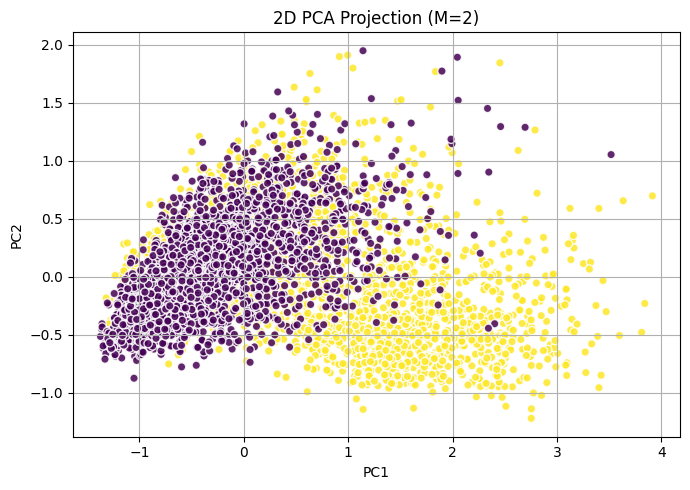

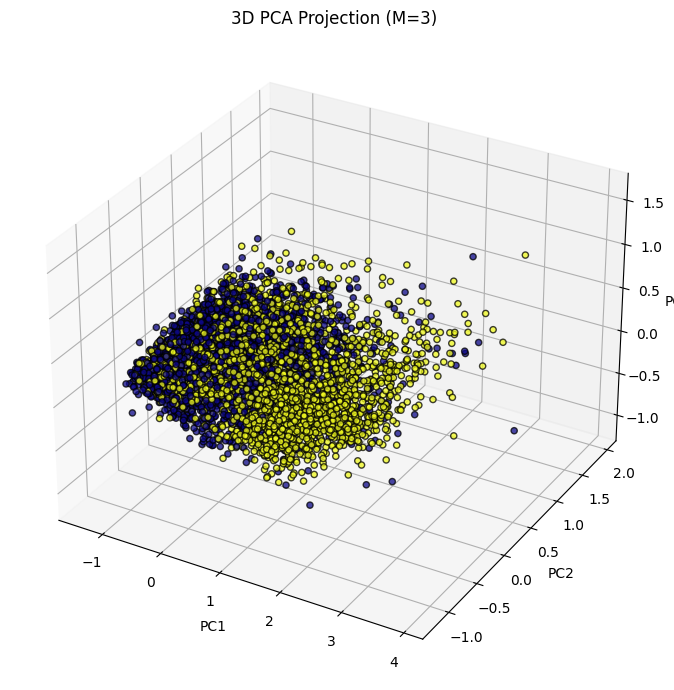

PCA with 5 components explains 82.14% of the variance.
PCA with 10 components explains 89.25% of the variance.
PCA with 20 components explains 94.36% of the variance.


In [7]:



# Defining a dictionary for configurations
pca_configs = {
    2: {"figsize": (7, 5), "cmap": "viridis", "title": "2D PCA Projection (M=2)"},
    3: {"figsize": (9, 7), "cmap": "plasma", "title": "3D PCA Projection (M=3)", "alpha": 0.75, "edgecolor": 'black'},
    5: {"info": True},
    10: {"info": True},
    20: {"info": True},
}

# Loop over the PCA configurations
for n_components, config in pca_configs.items():
    pca = PCA(n_components=n_components)
    x_reduced = pca.fit_transform(features)

    if n_components == 2:
        plt.figure(figsize=config["figsize"])
        plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=y, cmap=config["cmap"], edgecolors='w', alpha=0.85)
        plt.title(config["title"])
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif n_components == 3:
        fig = plt.figure(figsize=config["figsize"])
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            x_reduced[:, 0], x_reduced[:, 1], x_reduced[:, 2],
            c=y, cmap=config["cmap"],
            alpha=config.get("alpha", 0.8),
            edgecolor=config.get("edgecolor", 'k')
        )
        ax.set_title(config["title"])
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        plt.tight_layout()
        plt.show()

    else:
        # For 5, 10, 20 components, we just print the explained variance
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"PCA with {n_components} components explains {explained_var:.2%} of the variance.")

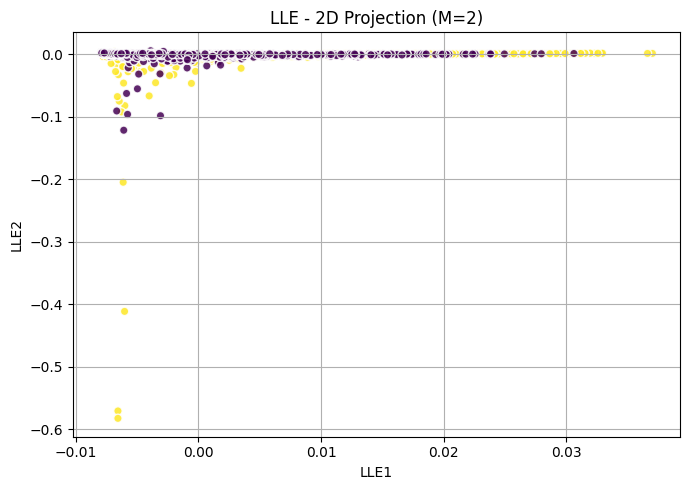

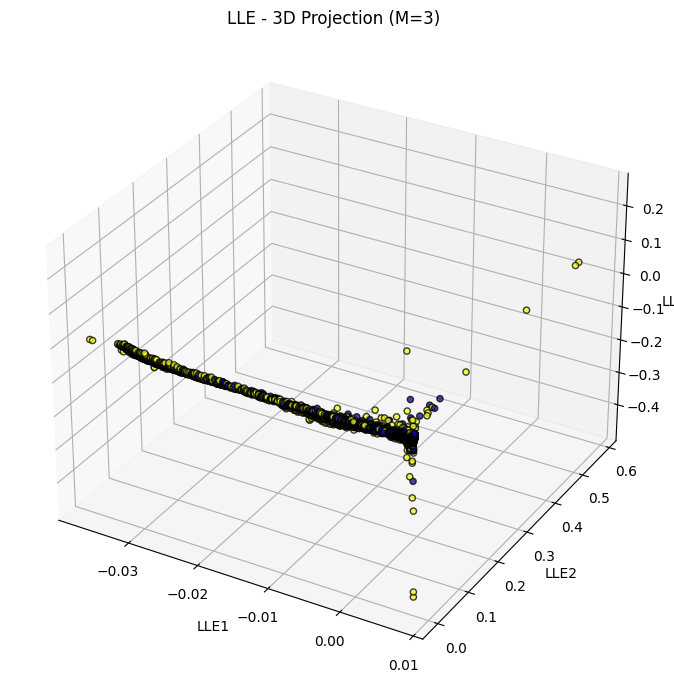

LLE with 5 components completed. Output shape: (6376, 5)
LLE with 10 components completed. Output shape: (6376, 10)
LLE with 20 components completed. Output shape: (6376, 20)


In [8]:



lle_configs = {
    2: {"figsize": (7, 5), "cmap": "viridis", "title": "LLE - 2D Projection (M=2)"},
    3: {"figsize": (9, 7), "cmap": "plasma", "title": "LLE - 3D Projection (M=3)", "alpha": 0.75, "edgecolor": 'black'},
    5: {"info": True},
    10: {"info": True},
    20: {"info": True},
}

for n_components, config in lle_configs.items():
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=10)
    x_lle = lle.fit_transform(features)

    if n_components == 2:
        plt.figure(figsize=config["figsize"])
        plt.scatter(x_lle[:, 0], x_lle[:, 1], c=y, cmap=config["cmap"], edgecolors='w', alpha=0.85)
        plt.title(config["title"])
        plt.xlabel("LLE1")
        plt.ylabel("LLE2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif n_components == 3:
        fig = plt.figure(figsize=config["figsize"])
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            x_lle[:, 0], x_lle[:, 1], x_lle[:, 2],
            c=y, cmap=config["cmap"],
            alpha=config.get("alpha", 0.8),
            edgecolor=config.get("edgecolor", 'k')
        )
        ax.set_title(config["title"])
        ax.set_xlabel("LLE1")
        ax.set_ylabel("LLE2")
        ax.set_zlabel("LLE3")
        plt.tight_layout()
        plt.show()

    else:
        print(f"LLE with {n_components} components completed. Output shape: {x_lle.shape}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


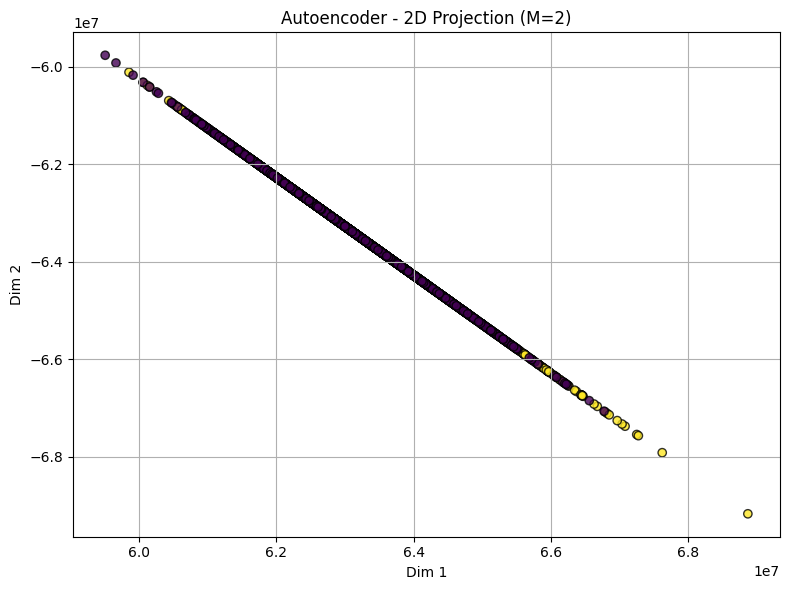

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


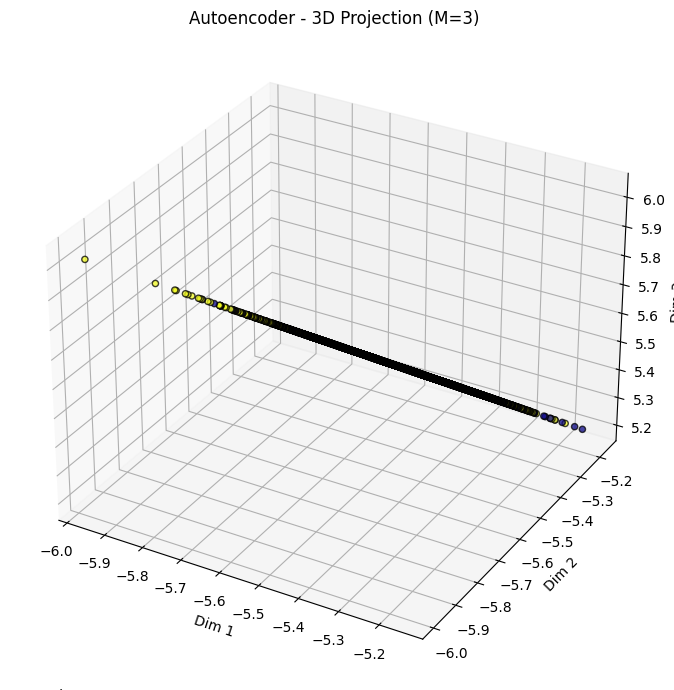

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autoencoder with 5 dimensions trained. Encoded shape: (6376, 5)
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Autoencoder with 10 dimensions trained. Encoded shape: (6376, 10)
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Autoencoder with 20 dimensions trained. Encoded shape: (6376, 20)


In [9]:


# Ensure reproducibility for later use
np.random.seed(42)


input_data = features  # CNN features
labels = y             # labeling

# Parameters
encoding_dims = [2, 3, 5, 10, 20]
hidden1, hidden2 = 256, 128
activation = "relu"
final_activation = "sigmoid"
loss_fn = "binary_crossentropy"
epochs = 10
input_dim = input_data.shape[1]

# create output folder
os.makedirs("encoded_outputs", exist_ok=True)

# Store outputs for immediate use (optional)
encoded_outputs = {}

for dim in encoding_dims:
    # Build autoencoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(hidden1, activation=activation)(input_layer)
    encoded = Dense(hidden2, activation=activation)(encoded)
    bottleneck = Dense(dim)(encoded)
    decoded = Dense(hidden2, activation=activation)(bottleneck)
    decoded = Dense(hidden1, activation=activation)(decoded)
    output_layer = Dense(input_dim, activation=final_activation)(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bottleneck)

    autoencoder.compile(optimizer=Adam(), loss=loss_fn)
    autoencoder.fit(input_data, input_data, epochs=epochs, verbose=0)

    # Encode and save
    x_encoded = encoder.predict(input_data)
    encoded_outputs[dim] = x_encoded
    np.save(f"encoded_outputs/x_encoded_{dim}.npy", x_encoded)

    # Visualize
    if dim == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(x_encoded[:, 0], x_encoded[:, 1], c=labels, cmap="viridis", alpha=0.8, edgecolors='k')
        plt.title("Autoencoder - 2D Projection (M=2)")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif dim == 3:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_encoded[:, 0], x_encoded[:, 1], x_encoded[:, 2],
                   c=labels, cmap="plasma", alpha=0.75, edgecolor='black')
        ax.set_title("Autoencoder - 3D Projection (M=3)")
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
        ax.set_zlabel("Dim 3")
        plt.tight_layout()
        plt.show()

    else:
        print(f"Autoencoder with {dim} dimensions trained. Encoded shape: {x_encoded.shape}")

In [10]:
!pip install pyclustering

kmeans_euclidean | M=2 | K=2 | Silhouette=0.5801 | Purity=0.6230 | F1=0.6230
kmeans_euclidean | M=2 | K=3 | Silhouette=0.4688 | Purity=0.6341 | F1=0.4617
kmeans_euclidean | M=2 | K=4 | Silhouette=0.3920 | Purity=0.6288 | F1=0.3494
kmeans_euclidean | M=2 | K=5 | Silhouette=0.3943 | Purity=0.6288 | F1=0.1987
kmeans_euclidean | M=2 | K=6 | Silhouette=0.3618 | Purity=0.6366 | F1=0.2458
kmeans_euclidean | M=2 | K=7 | Silhouette=0.3699 | Purity=0.6332 | F1=0.1231
kmeans_euclidean | M=2 | K=8 | Silhouette=0.3463 | Purity=0.6369 | F1=0.1826
kmeans_euclidean | M=2 | K=9 | Silhouette=0.3620 | Purity=0.6319 | F1=0.2125
kmeans_euclidean | M=2 | K=10 | Silhouette=0.3531 | Purity=0.6339 | F1=0.0790


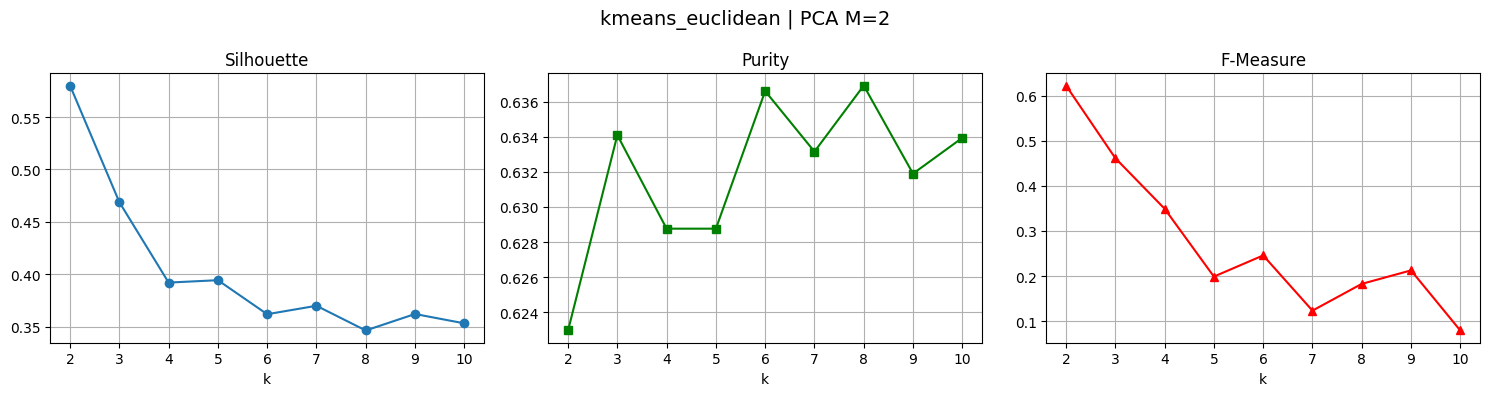

Best k = 2 with Silhouette = 0.5801

kmeans_cosine | M=2 | K=2 | Silhouette=0.5084 | Purity=0.6371 | F1=0.6371
kmeans_cosine | M=2 | K=3 | Silhouette=0.4411 | Purity=0.6349 | F1=0.5282
kmeans_cosine | M=2 | K=4 | Silhouette=0.3234 | Purity=0.6374 | F1=0.3614
kmeans_cosine | M=2 | K=5 | Silhouette=0.2855 | Purity=0.6360 | F1=0.2489
kmeans_cosine | M=2 | K=6 | Silhouette=0.2787 | Purity=0.6346 | F1=0.0696
kmeans_cosine | M=2 | K=7 | Silhouette=0.2246 | Purity=0.6379 | F1=0.0888
kmeans_cosine | M=2 | K=8 | Silhouette=0.2138 | Purity=0.6361 | F1=0.2955
kmeans_cosine | M=2 | K=9 | Silhouette=0.1746 | Purity=0.6360 | F1=0.1628
kmeans_cosine | M=2 | K=10 | Silhouette=0.1370 | Purity=0.6360 | F1=0.1181


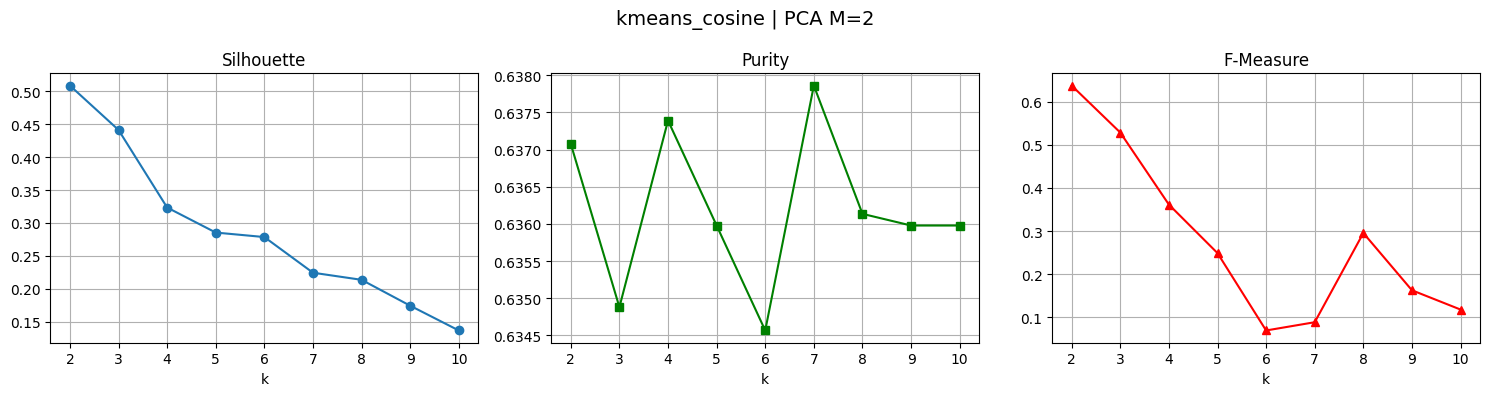

Best k = 2 with Silhouette = 0.5084

agglomerative | M=2 | K=2 | Silhouette=0.5445 | Purity=0.6269 | F1=0.6269
agglomerative | M=2 | K=3 | Silhouette=0.4332 | Purity=0.6346 | F1=0.2756
agglomerative | M=2 | K=4 | Silhouette=0.4292 | Purity=0.6346 | F1=0.4715
agglomerative | M=2 | K=5 | Silhouette=0.3331 | Purity=0.6346 | F1=0.2004
agglomerative | M=2 | K=6 | Silhouette=0.3402 | Purity=0.6346 | F1=0.1879
agglomerative | M=2 | K=7 | Silhouette=0.3294 | Purity=0.6346 | F1=0.2530
agglomerative | M=2 | K=8 | Silhouette=0.3139 | Purity=0.6346 | F1=0.2774
agglomerative | M=2 | K=9 | Silhouette=0.3094 | Purity=0.6346 | F1=0.1065
agglomerative | M=2 | K=10 | Silhouette=0.3106 | Purity=0.6346 | F1=0.1939


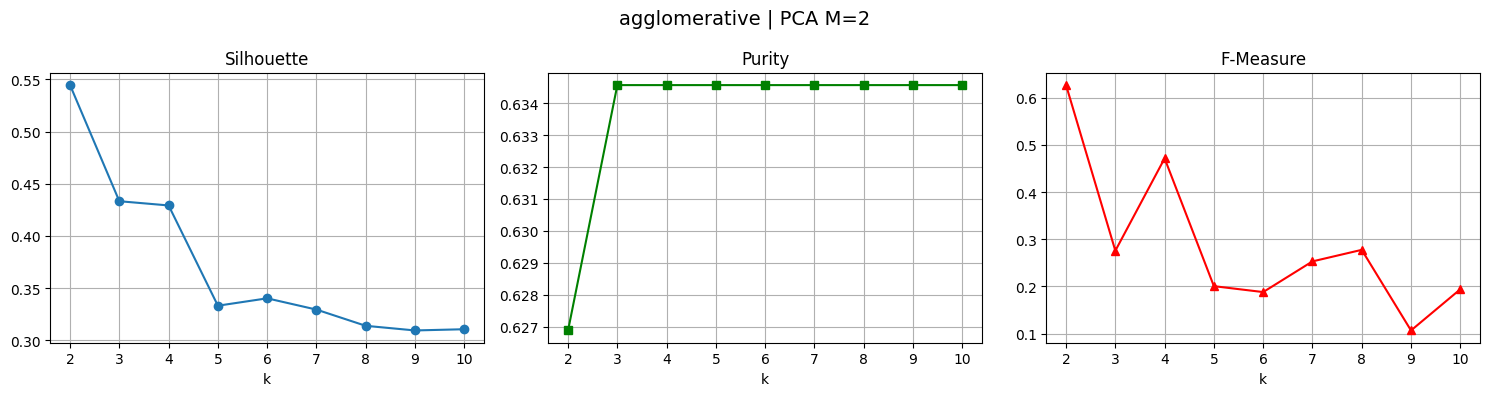

Best k = 2 with Silhouette = 0.5445

kmeans_euclidean | M=3 | K=2 | Silhouette=0.5420 | Purity=0.6234 | F1=0.3766
kmeans_euclidean | M=3 | K=3 | Silhouette=0.4262 | Purity=0.6358 | F1=0.4686
kmeans_euclidean | M=3 | K=4 | Silhouette=0.3378 | Purity=0.6314 | F1=0.3805
kmeans_euclidean | M=3 | K=5 | Silhouette=0.3310 | Purity=0.6328 | F1=0.2342
kmeans_euclidean | M=3 | K=6 | Silhouette=0.3318 | Purity=0.6339 | F1=0.1120
kmeans_euclidean | M=3 | K=7 | Silhouette=0.3066 | Purity=0.6346 | F1=0.0712
kmeans_euclidean | M=3 | K=8 | Silhouette=0.2892 | Purity=0.6332 | F1=0.1088
kmeans_euclidean | M=3 | K=9 | Silhouette=0.2968 | Purity=0.6333 | F1=0.1035
kmeans_euclidean | M=3 | K=10 | Silhouette=0.2683 | Purity=0.6341 | F1=0.1146


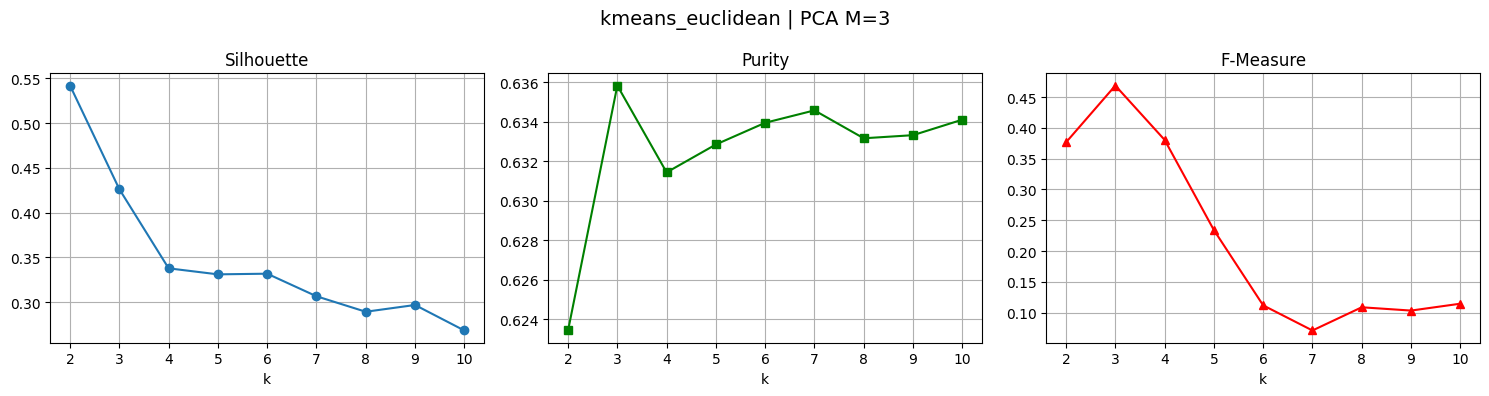

Best k = 2 with Silhouette = 0.5420

kmeans_cosine | M=3 | K=2 | Silhouette=0.4726 | Purity=0.6364 | F1=0.6364
kmeans_cosine | M=3 | K=3 | Silhouette=0.3991 | Purity=0.6380 | F1=0.4420
kmeans_cosine | M=3 | K=4 | Silhouette=0.2956 | Purity=0.6371 | F1=0.2760
kmeans_cosine | M=3 | K=5 | Silhouette=0.2636 | Purity=0.6352 | F1=0.1780
kmeans_cosine | M=3 | K=6 | Silhouette=0.2642 | Purity=0.6390 | F1=0.3775
kmeans_cosine | M=3 | K=7 | Silhouette=0.2236 | Purity=0.6371 | F1=0.1975
kmeans_cosine | M=3 | K=8 | Silhouette=0.2102 | Purity=0.6396 | F1=0.2806
kmeans_cosine | M=3 | K=9 | Silhouette=0.2199 | Purity=0.6388 | F1=0.0787
kmeans_cosine | M=3 | K=10 | Silhouette=0.1926 | Purity=0.6396 | F1=0.2026


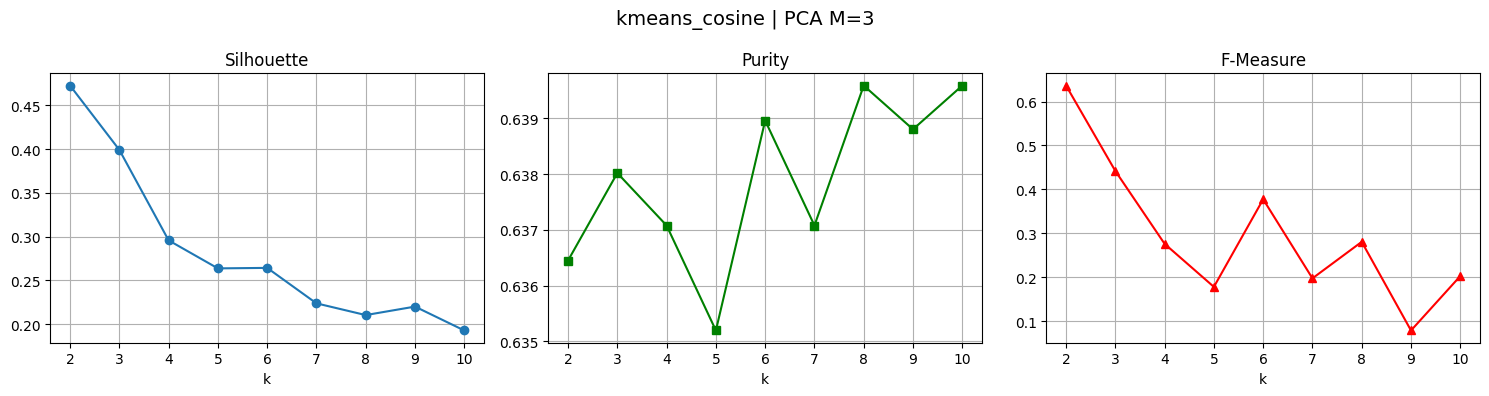

Best k = 2 with Silhouette = 0.4726

agglomerative | M=3 | K=2 | Silhouette=0.5300 | Purity=0.6063 | F1=0.6063
agglomerative | M=3 | K=3 | Silhouette=0.4106 | Purity=0.6339 | F1=0.1719
agglomerative | M=3 | K=4 | Silhouette=0.3941 | Purity=0.6339 | F1=0.1949
agglomerative | M=3 | K=5 | Silhouette=0.3640 | Purity=0.6339 | F1=0.3614
agglomerative | M=3 | K=6 | Silhouette=0.2452 | Purity=0.6339 | F1=0.1451
agglomerative | M=3 | K=7 | Silhouette=0.2494 | Purity=0.6341 | F1=0.2517
agglomerative | M=3 | K=8 | Silhouette=0.2402 | Purity=0.6341 | F1=0.0878
agglomerative | M=3 | K=9 | Silhouette=0.2388 | Purity=0.6341 | F1=0.0894
agglomerative | M=3 | K=10 | Silhouette=0.2316 | Purity=0.6341 | F1=0.0343


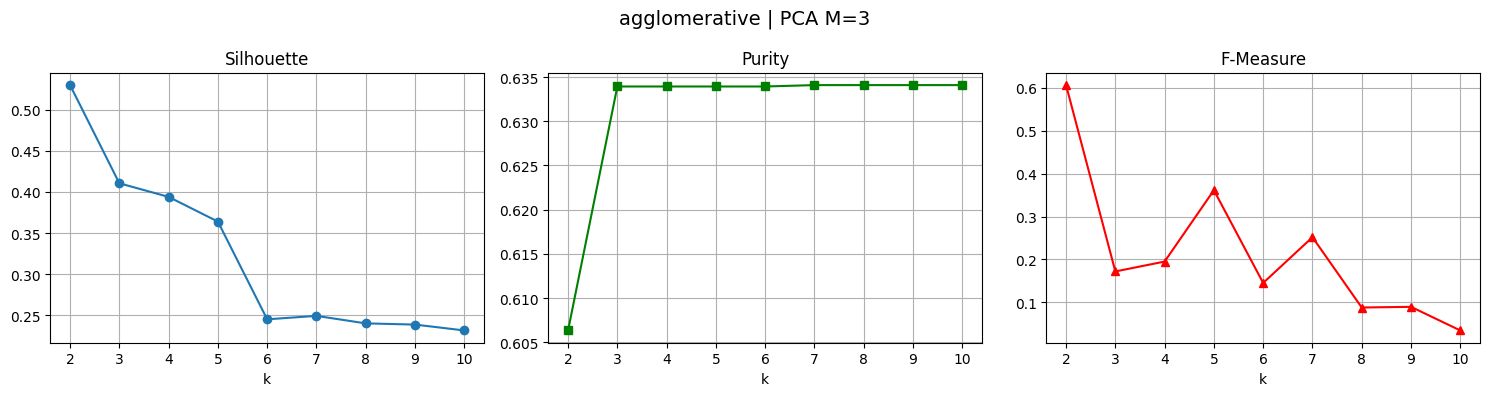

Best k = 2 with Silhouette = 0.5300

kmeans_euclidean | M=5 | K=2 | Silhouette=0.5014 | Purity=0.6242 | F1=0.3758
kmeans_euclidean | M=5 | K=3 | Silhouette=0.3744 | Purity=0.6393 | F1=0.4994
kmeans_euclidean | M=5 | K=4 | Silhouette=0.2743 | Purity=0.6319 | F1=0.3112
kmeans_euclidean | M=5 | K=5 | Silhouette=0.2591 | Purity=0.6366 | F1=0.1953
kmeans_euclidean | M=5 | K=6 | Silhouette=0.2603 | Purity=0.6426 | F1=0.1231
kmeans_euclidean | M=5 | K=7 | Silhouette=0.2402 | Purity=0.6444 | F1=0.1175
kmeans_euclidean | M=5 | K=8 | Silhouette=0.2283 | Purity=0.6375 | F1=0.2075
kmeans_euclidean | M=5 | K=9 | Silhouette=0.2160 | Purity=0.6466 | F1=0.0947
kmeans_euclidean | M=5 | K=10 | Silhouette=0.2125 | Purity=0.6465 | F1=0.0830


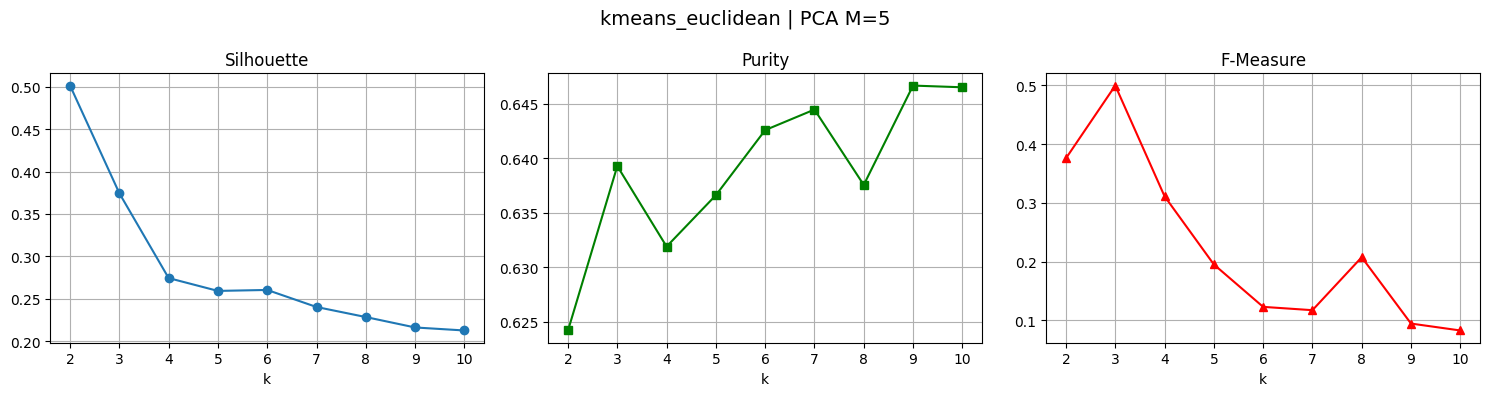

Best k = 2 with Silhouette = 0.5014

kmeans_cosine | M=5 | K=2 | Silhouette=0.4306 | Purity=0.6361 | F1=0.6361
kmeans_cosine | M=5 | K=3 | Silhouette=0.3314 | Purity=0.6349 | F1=0.5340
kmeans_cosine | M=5 | K=4 | Silhouette=0.2395 | Purity=0.6391 | F1=0.1949
kmeans_cosine | M=5 | K=5 | Silhouette=0.1965 | Purity=0.6391 | F1=0.3043
kmeans_cosine | M=5 | K=6 | Silhouette=0.2083 | Purity=0.6401 | F1=0.2726
kmeans_cosine | M=5 | K=7 | Silhouette=0.1968 | Purity=0.6455 | F1=0.2831
kmeans_cosine | M=5 | K=8 | Silhouette=0.1822 | Purity=0.6427 | F1=0.1540
kmeans_cosine | M=5 | K=9 | Silhouette=0.1716 | Purity=0.6488 | F1=0.1404
kmeans_cosine | M=5 | K=10 | Silhouette=0.1761 | Purity=0.6462 | F1=0.1270


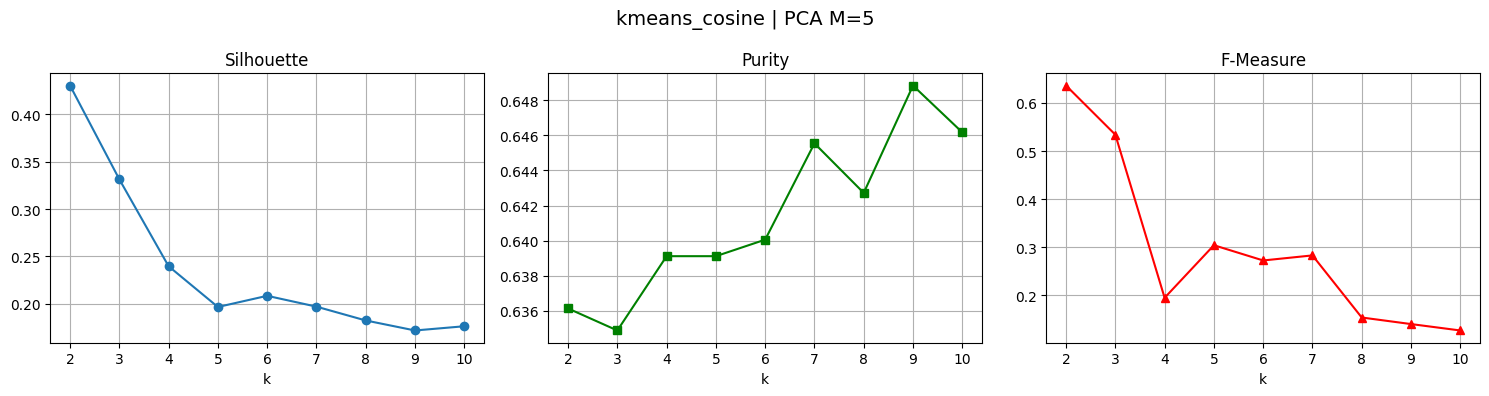

Best k = 2 with Silhouette = 0.4306

agglomerative | M=5 | K=2 | Silhouette=0.5094 | Purity=0.6004 | F1=0.6004
agglomerative | M=5 | K=3 | Silhouette=0.3375 | Purity=0.6399 | F1=0.2445
agglomerative | M=5 | K=4 | Silhouette=0.3198 | Purity=0.6399 | F1=0.4266
agglomerative | M=5 | K=5 | Silhouette=0.1671 | Purity=0.6399 | F1=0.2108
agglomerative | M=5 | K=6 | Silhouette=0.1754 | Purity=0.6399 | F1=0.1104
agglomerative | M=5 | K=7 | Silhouette=0.1716 | Purity=0.6399 | F1=0.1288
agglomerative | M=5 | K=8 | Silhouette=0.1655 | Purity=0.6426 | F1=0.2258
agglomerative | M=5 | K=9 | Silhouette=0.1671 | Purity=0.6426 | F1=0.0781
agglomerative | M=5 | K=10 | Silhouette=0.1684 | Purity=0.6426 | F1=0.0881


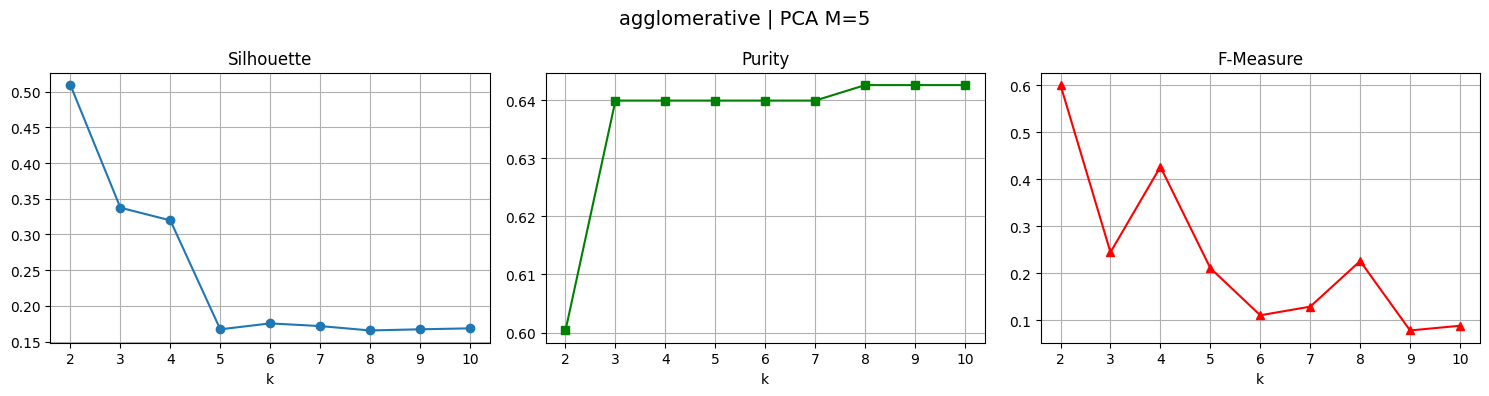

Best k = 2 with Silhouette = 0.5094

kmeans_euclidean | M=10 | K=2 | Silhouette=0.4712 | Purity=0.6237 | F1=0.6237
kmeans_euclidean | M=10 | K=3 | Silhouette=0.3373 | Purity=0.6380 | F1=0.3530
kmeans_euclidean | M=10 | K=4 | Silhouette=0.2339 | Purity=0.6324 | F1=0.2826
kmeans_euclidean | M=10 | K=5 | Silhouette=0.2200 | Purity=0.6358 | F1=0.1324
kmeans_euclidean | M=10 | K=6 | Silhouette=0.2230 | Purity=0.6416 | F1=0.1965
kmeans_euclidean | M=10 | K=7 | Silhouette=0.1993 | Purity=0.6424 | F1=0.2745
kmeans_euclidean | M=10 | K=8 | Silhouette=0.1840 | Purity=0.6415 | F1=0.1217
kmeans_euclidean | M=10 | K=9 | Silhouette=0.1633 | Purity=0.6350 | F1=0.1815
kmeans_euclidean | M=10 | K=10 | Silhouette=0.1666 | Purity=0.6432 | F1=0.1107


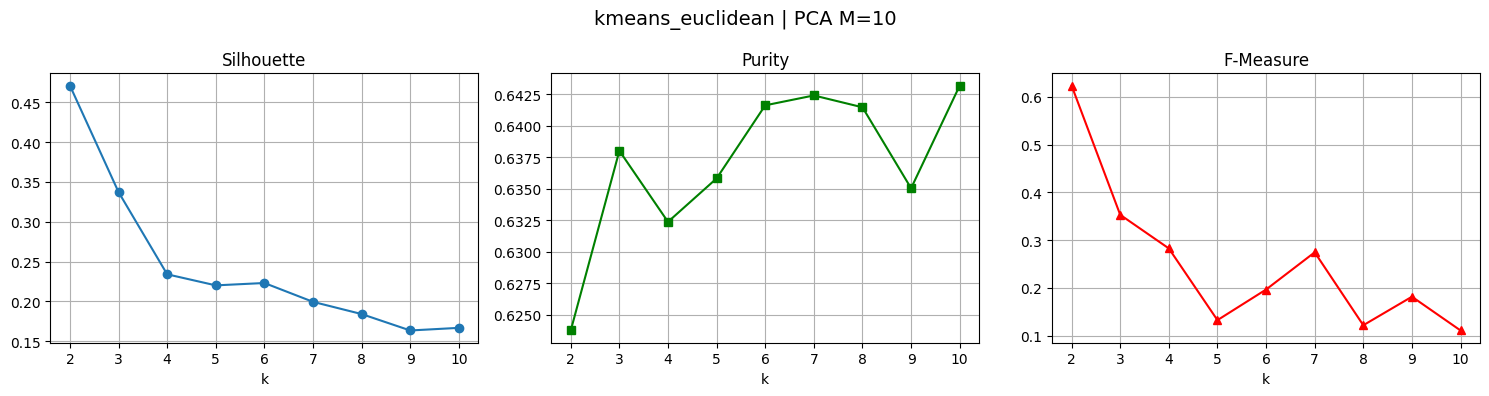

Best k = 2 with Silhouette = 0.4712

kmeans_cosine | M=10 | K=2 | Silhouette=0.3999 | Purity=0.6358 | F1=0.6358
kmeans_cosine | M=10 | K=3 | Silhouette=0.3225 | Purity=0.6379 | F1=0.5260
kmeans_cosine | M=10 | K=4 | Silhouette=0.2264 | Purity=0.6386 | F1=0.2193
kmeans_cosine | M=10 | K=5 | Silhouette=0.1952 | Purity=0.6374 | F1=0.3744
kmeans_cosine | M=10 | K=6 | Silhouette=0.1846 | Purity=0.6416 | F1=0.1898
kmeans_cosine | M=10 | K=7 | Silhouette=0.1657 | Purity=0.6476 | F1=0.3198
kmeans_cosine | M=10 | K=8 | Silhouette=0.1564 | Purity=0.6468 | F1=0.2961
kmeans_cosine | M=10 | K=9 | Silhouette=0.1584 | Purity=0.6438 | F1=0.1764
kmeans_cosine | M=10 | K=10 | Silhouette=0.1485 | Purity=0.6377 | F1=0.2817


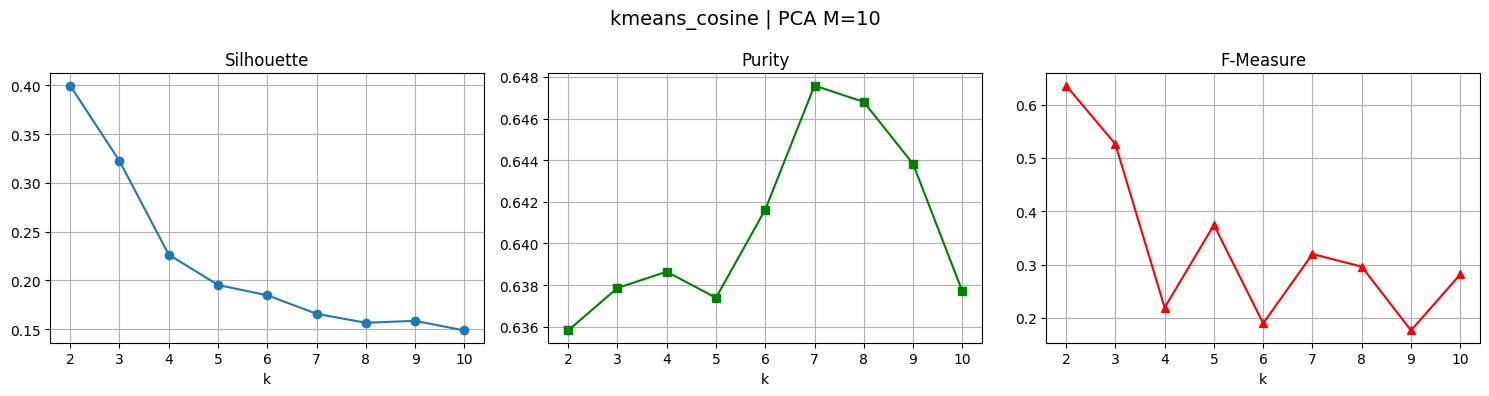

Best k = 2 with Silhouette = 0.3999

agglomerative | M=10 | K=2 | Silhouette=0.4857 | Purity=0.6002 | F1=0.6002
agglomerative | M=10 | K=3 | Silhouette=0.2969 | Purity=0.6299 | F1=0.3107
agglomerative | M=10 | K=4 | Silhouette=0.2105 | Purity=0.6299 | F1=0.1222
agglomerative | M=10 | K=5 | Silhouette=0.1981 | Purity=0.6299 | F1=0.1750
agglomerative | M=10 | K=6 | Silhouette=0.2026 | Purity=0.6299 | F1=0.3752
agglomerative | M=10 | K=7 | Silhouette=0.1017 | Purity=0.6299 | F1=0.1415
agglomerative | M=10 | K=8 | Silhouette=0.1043 | Purity=0.6299 | F1=0.3038
agglomerative | M=10 | K=9 | Silhouette=0.0993 | Purity=0.6299 | F1=0.1862
agglomerative | M=10 | K=10 | Silhouette=0.0987 | Purity=0.6415 | F1=0.0549


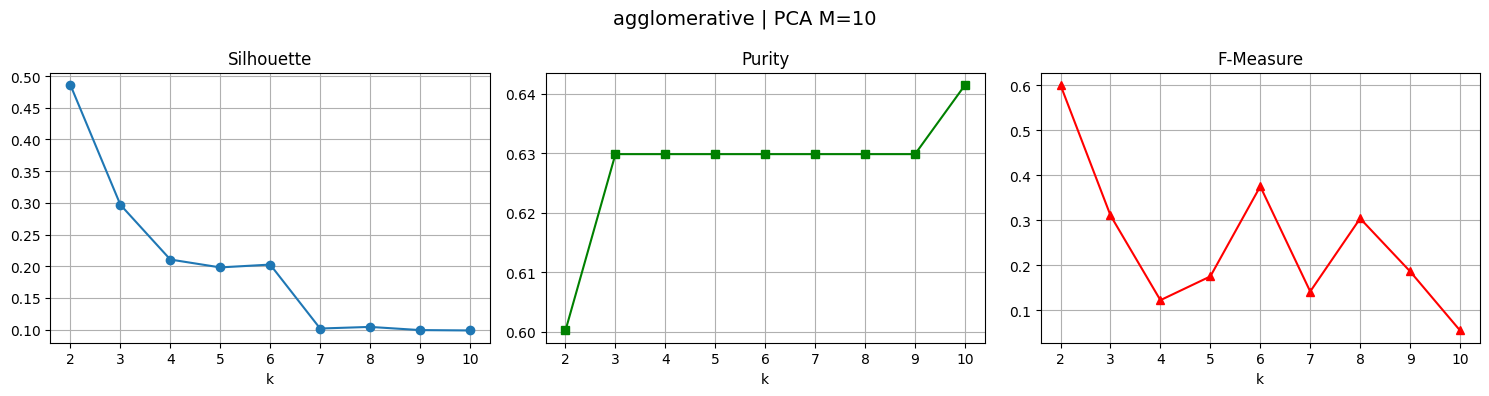

Best k = 2 with Silhouette = 0.4857

kmeans_euclidean | M=20 | K=2 | Silhouette=0.4514 | Purity=0.6237 | F1=0.6237
kmeans_euclidean | M=20 | K=3 | Silhouette=0.3133 | Purity=0.6363 | F1=0.3545
kmeans_euclidean | M=20 | K=4 | Silhouette=0.2141 | Purity=0.6316 | F1=0.3497
kmeans_euclidean | M=20 | K=5 | Silhouette=0.2013 | Purity=0.6346 | F1=0.1959
kmeans_euclidean | M=20 | K=6 | Silhouette=0.1983 | Purity=0.6424 | F1=0.1206
kmeans_euclidean | M=20 | K=7 | Silhouette=0.1631 | Purity=0.6399 | F1=0.1432
kmeans_euclidean | M=20 | K=8 | Silhouette=0.1553 | Purity=0.6452 | F1=0.1496
kmeans_euclidean | M=20 | K=9 | Silhouette=0.1605 | Purity=0.6465 | F1=0.2396
kmeans_euclidean | M=20 | K=10 | Silhouette=0.1465 | Purity=0.6407 | F1=0.1626


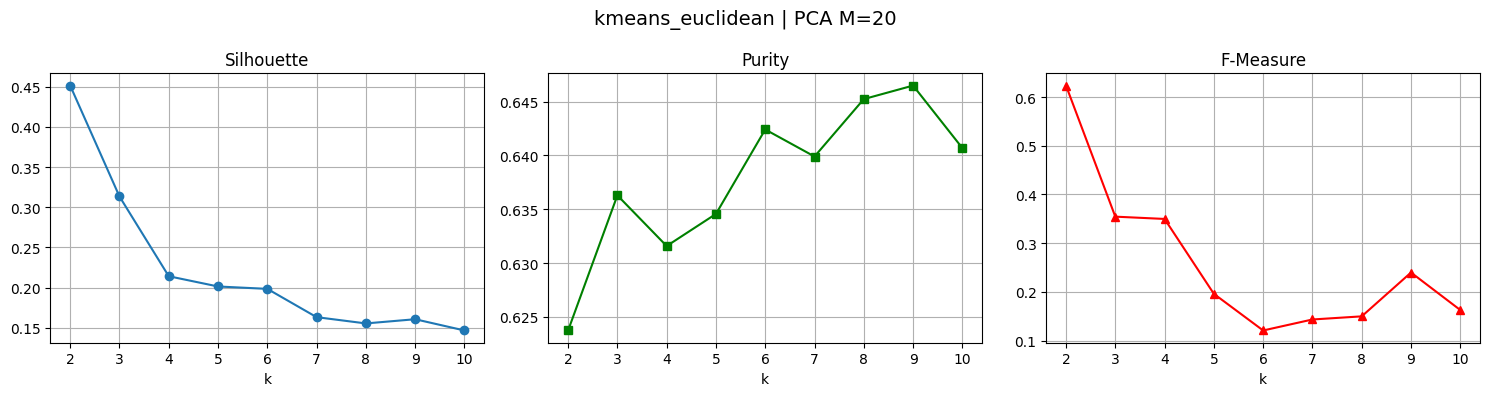

Best k = 2 with Silhouette = 0.4514

kmeans_cosine | M=20 | K=2 | Silhouette=0.3806 | Purity=0.6357 | F1=0.6357
kmeans_cosine | M=20 | K=3 | Silhouette=0.3023 | Purity=0.6374 | F1=0.5267
kmeans_cosine | M=20 | K=4 | Silhouette=0.2055 | Purity=0.6404 | F1=0.2876
kmeans_cosine | M=20 | K=5 | Silhouette=0.1696 | Purity=0.6383 | F1=0.1735
kmeans_cosine | M=20 | K=6 | Silhouette=0.1710 | Purity=0.6375 | F1=0.3347
kmeans_cosine | M=20 | K=7 | Silhouette=0.1154 | Purity=0.6385 | F1=0.2778
kmeans_cosine | M=20 | K=8 | Silhouette=0.1384 | Purity=0.6443 | F1=0.0883
kmeans_cosine | M=20 | K=9 | Silhouette=0.1007 | Purity=0.6385 | F1=0.0958
kmeans_cosine | M=20 | K=10 | Silhouette=0.1247 | Purity=0.6361 | F1=0.1550


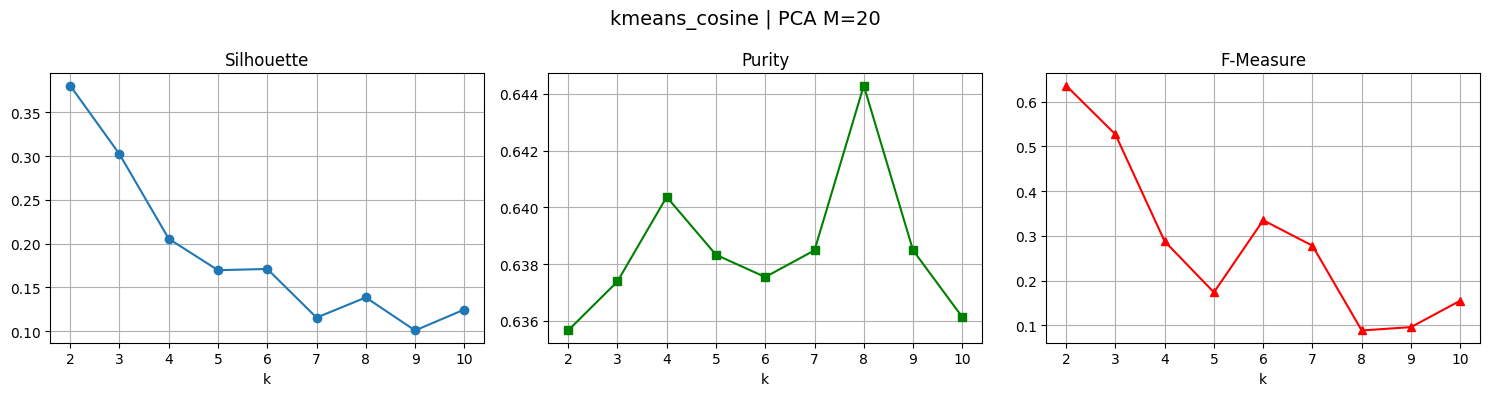

Best k = 2 with Silhouette = 0.3806

agglomerative | M=20 | K=2 | Silhouette=0.4537 | Purity=0.6084 | F1=0.6084
agglomerative | M=20 | K=3 | Silhouette=0.2857 | Purity=0.6482 | F1=0.1746
agglomerative | M=20 | K=4 | Silhouette=0.2652 | Purity=0.6482 | F1=0.1942
agglomerative | M=20 | K=5 | Silhouette=0.2138 | Purity=0.6482 | F1=0.4078
agglomerative | M=20 | K=6 | Silhouette=0.1097 | Purity=0.6482 | F1=0.1515
agglomerative | M=20 | K=7 | Silhouette=0.1105 | Purity=0.6482 | F1=0.2961
agglomerative | M=20 | K=8 | Silhouette=0.1040 | Purity=0.6482 | F1=0.0632
agglomerative | M=20 | K=9 | Silhouette=0.0929 | Purity=0.6482 | F1=0.1250
agglomerative | M=20 | K=10 | Silhouette=0.0952 | Purity=0.6482 | F1=0.1808


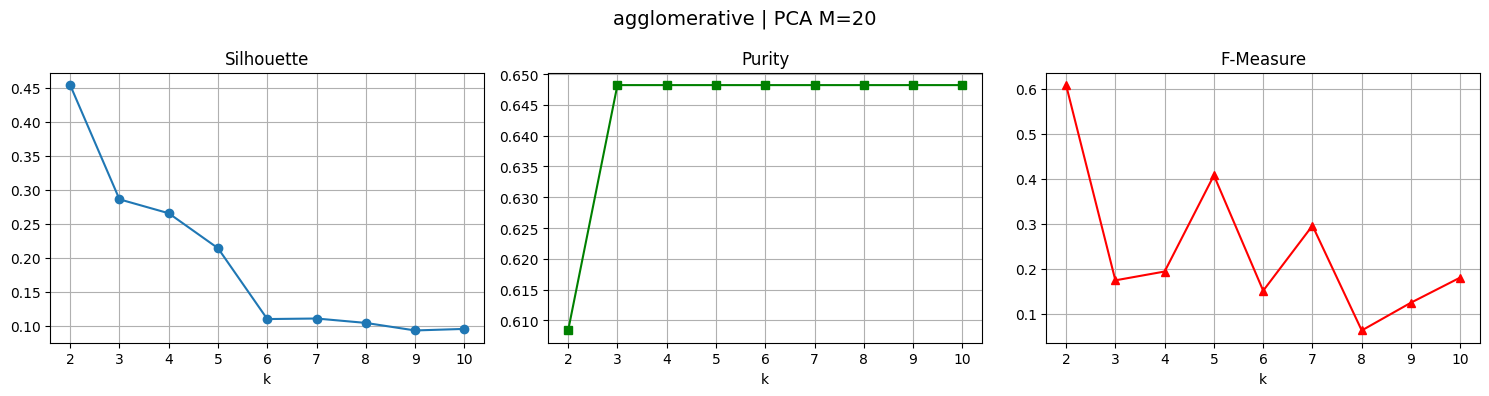

Best k = 2 with Silhouette = 0.4537



In [11]:

# Input data
X = features
true_labels = y
pca_dims = [2, 3, 5, 10, 20]
cluster_range = range(2, 11)

# Custom cosine distance function
def my_cosine(a, b):
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    return 1.0 - np.dot(a, b.T) / (a_norm * b_norm)

def evaluate_clustering(method_name, X_proj, labels_true):
    silhouette_scores = []
    purity_scores = []
    fmeasure_scores = []
    best_k = -1
    best_silhouette = -1

    for k in cluster_range:
        if method_name == "kmeans_euclidean":
            model = KMeans(n_clusters=k, n_init="auto")
            labels = model.fit_predict(X_proj)

        elif method_name == "kmeans_cosine":
            centers = kmeans_plusplus_initializer(X_proj, k).initialize()
            metric_cos = distance_metric(type_metric.USER_DEFINED, func=my_cosine)
            model = kmeans(X_proj, centers, metric=metric_cos)
            model.process()
            labels = model.predict(X_proj)

        elif method_name == "agglomerative":
            model = AgglomerativeClustering(n_clusters=k, metric="euclidean", linkage="ward")
            labels = model.fit_predict(X_proj)

        else:
            raise ValueError("Unknown clustering method")

        silhouette = silhouette_score(X_proj, labels)
        contingency = metrics.cluster.contingency_matrix(labels_true, labels)
        purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)
        fmeasure = f1_score(labels_true, labels, average="micro")

        silhouette_scores.append(silhouette)
        purity_scores.append(purity)
        fmeasure_scores.append(fmeasure)

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

        print(f"{method_name} | M={X_proj.shape[1]} | K={k} | Silhouette={silhouette:.4f} | Purity={purity:.4f} | F1={fmeasure:.4f}")

    # Plot results
    ks = list(cluster_range)
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"{method_name} | PCA M={X_proj.shape[1]}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.plot(ks, silhouette_scores, marker='o')
    plt.title("Silhouette")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(ks, purity_scores, marker='s', color='g')
    plt.title("Purity")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(ks, fmeasure_scores, marker='^', color='r')
    plt.title("F-Measure")
    plt.xlabel("k")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Best k = {best_k} with Silhouette = {best_silhouette:.4f}\n")


# Main loop over PCA dimensions
for dim in pca_dims:
    pca = PCA(n_components=dim)
    X_proj = pca.fit_transform(X)

    evaluate_clustering("kmeans_euclidean", X_proj, true_labels)
    evaluate_clustering("kmeans_cosine", X_proj, true_labels)
    evaluate_clustering("agglomerative", X_proj, true_labels)

kmeans_euclidean | M=2 | K=2 | Silhouette=0.8073 | Purity=0.6159 | F1=0.6159
kmeans_euclidean | M=2 | K=3 | Silhouette=0.8148 | Purity=0.6162 | F1=0.6157
kmeans_euclidean | M=2 | K=4 | Silhouette=0.7382 | Purity=0.6347 | F1=0.0657
kmeans_euclidean | M=2 | K=5 | Silhouette=0.7412 | Purity=0.6321 | F1=0.0663
kmeans_euclidean | M=2 | K=6 | Silhouette=0.7068 | Purity=0.6352 | F1=0.5154
kmeans_euclidean | M=2 | K=7 | Silhouette=0.7067 | Purity=0.6343 | F1=0.2955
kmeans_euclidean | M=2 | K=8 | Silhouette=0.7067 | Purity=0.6343 | F1=0.2061
kmeans_euclidean | M=2 | K=9 | Silhouette=0.7198 | Purity=0.6319 | F1=0.4203
kmeans_euclidean | M=2 | K=10 | Silhouette=0.6850 | Purity=0.6336 | F1=0.0988


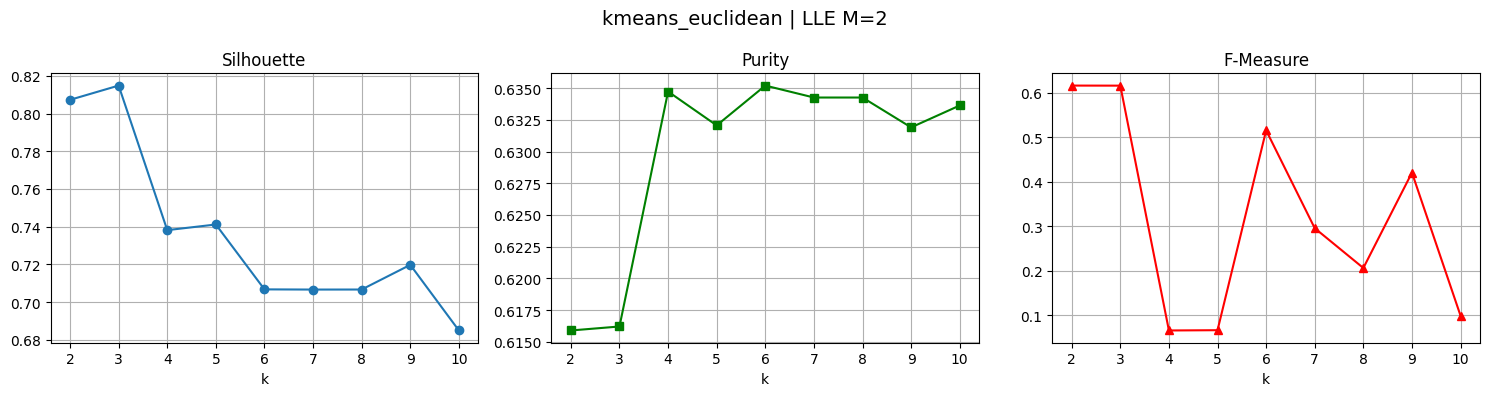

Best k = 3 with Silhouette = 0.8148

kmeans_cosine | M=2 | K=2 | Silhouette=0.7161 | Purity=0.6332 | F1=0.6332
kmeans_cosine | M=2 | K=3 | Silhouette=0.6759 | Purity=0.6377 | F1=0.5980
kmeans_cosine | M=2 | K=4 | Silhouette=0.5202 | Purity=0.6423 | F1=0.2290
kmeans_cosine | M=2 | K=5 | Silhouette=0.4926 | Purity=0.6416 | F1=0.5594
kmeans_cosine | M=2 | K=6 | Silhouette=0.4901 | Purity=0.6413 | F1=0.2902
kmeans_cosine | M=2 | K=7 | Silhouette=0.2599 | Purity=0.6415 | F1=0.3614
kmeans_cosine | M=2 | K=8 | Silhouette=0.2658 | Purity=0.6427 | F1=0.2127
kmeans_cosine | M=2 | K=9 | Silhouette=0.2525 | Purity=0.6416 | F1=0.3720
kmeans_cosine | M=2 | K=10 | Silhouette=0.2587 | Purity=0.6432 | F1=0.1109


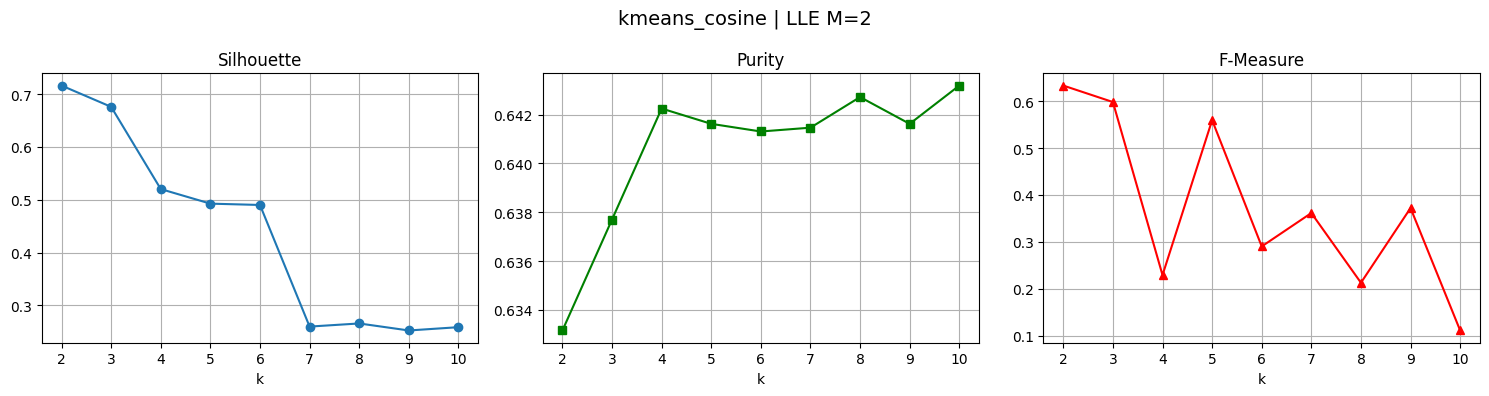

Best k = 2 with Silhouette = 0.7161

agglomerative | M=2 | K=2 | Silhouette=0.8054 | Purity=0.6161 | F1=0.6161
agglomerative | M=2 | K=3 | Silhouette=0.8133 | Purity=0.6165 | F1=0.6161
agglomerative | M=2 | K=4 | Silhouette=0.8201 | Purity=0.6170 | F1=0.6151
agglomerative | M=2 | K=5 | Silhouette=0.6888 | Purity=0.6306 | F1=0.0191
agglomerative | M=2 | K=6 | Silhouette=0.6859 | Purity=0.6306 | F1=0.0014
agglomerative | M=2 | K=7 | Silhouette=0.6858 | Purity=0.6306 | F1=0.1048
agglomerative | M=2 | K=8 | Silhouette=0.6860 | Purity=0.6306 | F1=0.0914
agglomerative | M=2 | K=9 | Silhouette=0.6719 | Purity=0.6332 | F1=0.0527
agglomerative | M=2 | K=10 | Silhouette=0.6648 | Purity=0.6347 | F1=0.0177


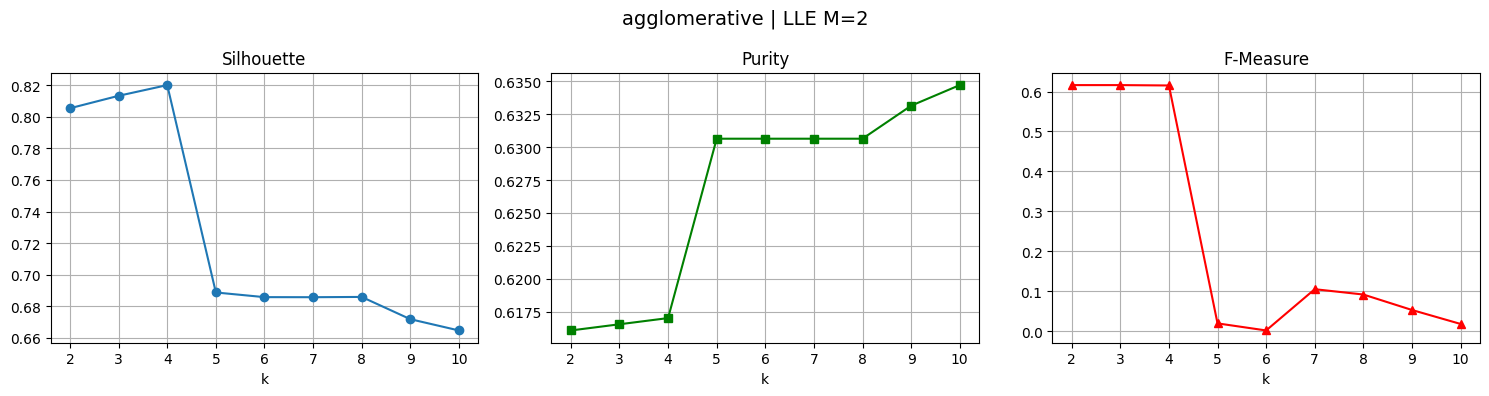

Best k = 4 with Silhouette = 0.8201

kmeans_euclidean | M=3 | K=2 | Silhouette=0.9656 | Purity=0.5323 | F1=0.4682
kmeans_euclidean | M=3 | K=3 | Silhouette=0.6511 | Purity=0.6159 | F1=0.4544
kmeans_euclidean | M=3 | K=4 | Silhouette=0.6564 | Purity=0.6165 | F1=0.4542
kmeans_euclidean | M=3 | K=5 | Silhouette=0.5291 | Purity=0.6358 | F1=0.3585
kmeans_euclidean | M=3 | K=6 | Silhouette=0.5070 | Purity=0.6347 | F1=0.0952
kmeans_euclidean | M=3 | K=7 | Silhouette=0.5094 | Purity=0.6357 | F1=0.0930
kmeans_euclidean | M=3 | K=8 | Silhouette=0.5144 | Purity=0.6335 | F1=0.0692
kmeans_euclidean | M=3 | K=9 | Silhouette=0.5108 | Purity=0.6336 | F1=0.3400
kmeans_euclidean | M=3 | K=10 | Silhouette=0.4858 | Purity=0.6357 | F1=0.1794


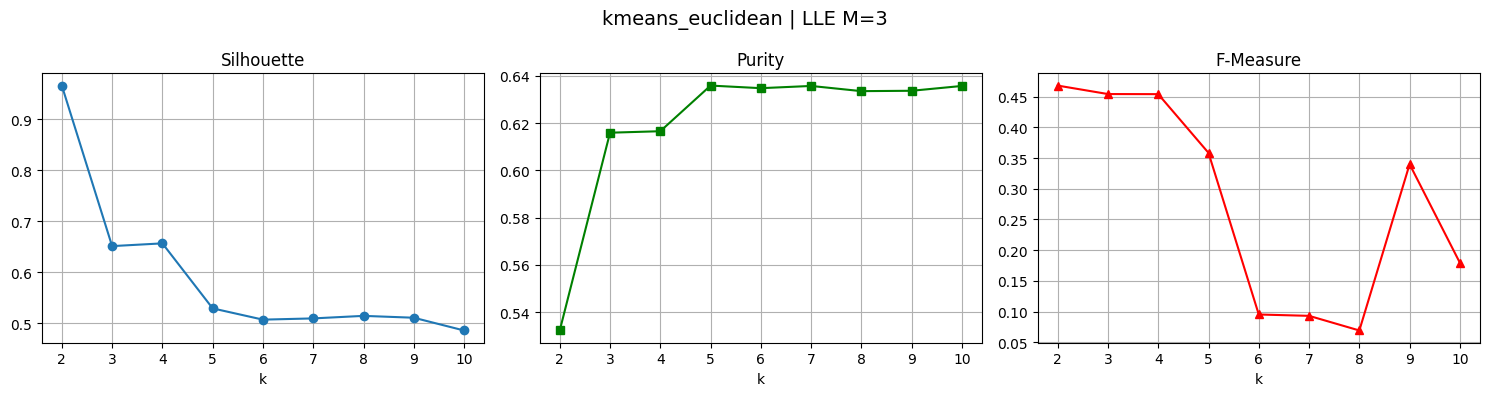

Best k = 2 with Silhouette = 0.9656

kmeans_cosine | M=3 | K=2 | Silhouette=0.5221 | Purity=0.6352 | F1=0.6352
kmeans_cosine | M=3 | K=3 | Silhouette=0.3951 | Purity=0.6159 | F1=0.4439
kmeans_cosine | M=3 | K=4 | Silhouette=0.4291 | Purity=0.6350 | F1=0.2891
kmeans_cosine | M=3 | K=5 | Silhouette=0.4080 | Purity=0.6335 | F1=0.3312
kmeans_cosine | M=3 | K=6 | Silhouette=0.3874 | Purity=0.6332 | F1=0.1686
kmeans_cosine | M=3 | K=7 | Silhouette=0.3402 | Purity=0.6369 | F1=0.1694
kmeans_cosine | M=3 | K=8 | Silhouette=0.3518 | Purity=0.6350 | F1=0.0715
kmeans_cosine | M=3 | K=9 | Silhouette=0.3451 | Purity=0.6360 | F1=0.1129
kmeans_cosine | M=3 | K=10 | Silhouette=0.3524 | Purity=0.6375 | F1=0.1815


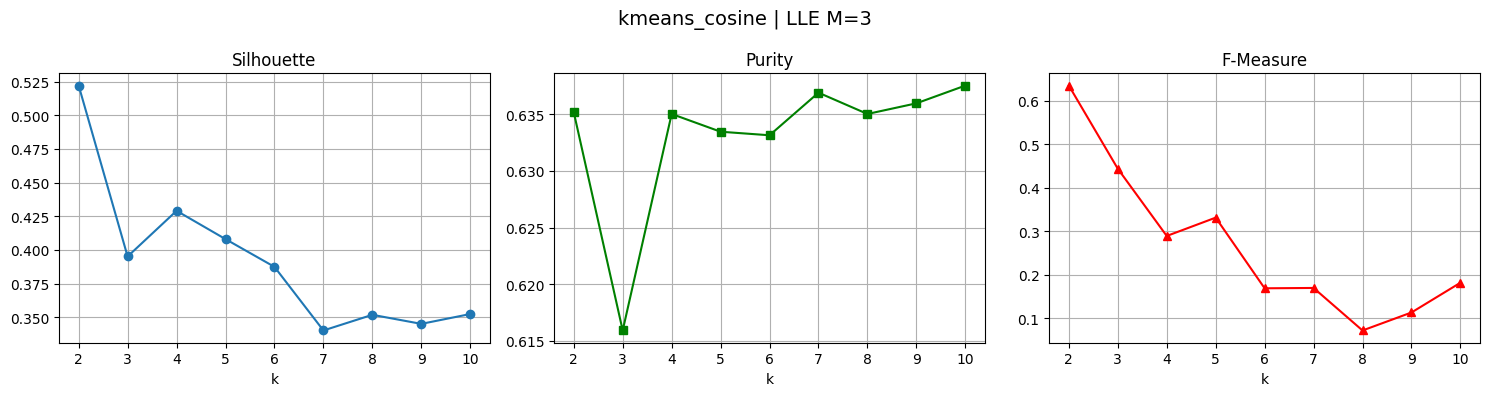

Best k = 2 with Silhouette = 0.5221

agglomerative | M=3 | K=2 | Silhouette=0.6431 | Purity=0.6095 | F1=0.6095
agglomerative | M=3 | K=3 | Silhouette=0.6500 | Purity=0.6099 | F1=0.6095
agglomerative | M=3 | K=4 | Silhouette=0.6541 | Purity=0.6103 | F1=0.6095
agglomerative | M=3 | K=5 | Silhouette=0.4326 | Purity=0.6103 | F1=0.4598
agglomerative | M=3 | K=6 | Silhouette=0.4754 | Purity=0.6368 | F1=0.4316
agglomerative | M=3 | K=7 | Silhouette=0.4894 | Purity=0.6372 | F1=0.1757
agglomerative | M=3 | K=8 | Silhouette=0.4847 | Purity=0.6372 | F1=0.0993
agglomerative | M=3 | K=9 | Silhouette=0.4779 | Purity=0.6372 | F1=0.2034
agglomerative | M=3 | K=10 | Silhouette=0.4777 | Purity=0.6374 | F1=0.3370


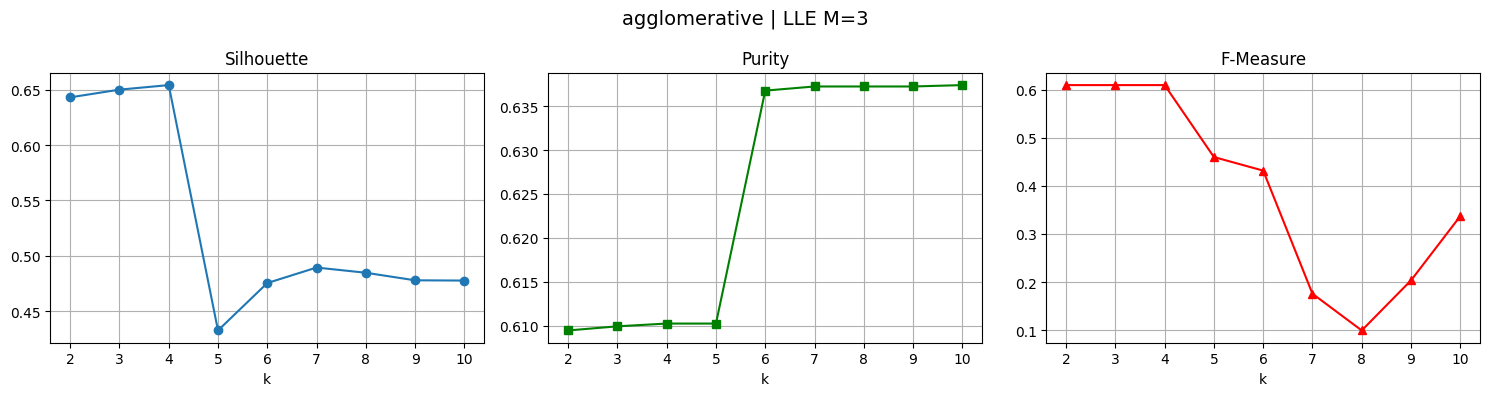

Best k = 4 with Silhouette = 0.6541

kmeans_euclidean | M=5 | K=2 | Silhouette=0.9655 | Purity=0.5323 | F1=0.4680
kmeans_euclidean | M=5 | K=3 | Silhouette=0.5700 | Purity=0.6136 | F1=0.6132
kmeans_euclidean | M=5 | K=4 | Silhouette=0.5718 | Purity=0.6137 | F1=0.6129
kmeans_euclidean | M=5 | K=5 | Silhouette=0.5760 | Purity=0.6140 | F1=0.6129
kmeans_euclidean | M=5 | K=6 | Silhouette=0.5653 | Purity=0.6285 | F1=0.3918
kmeans_euclidean | M=5 | K=7 | Silhouette=0.5576 | Purity=0.6288 | F1=0.3803
kmeans_euclidean | M=5 | K=8 | Silhouette=0.4145 | Purity=0.6283 | F1=0.2533
kmeans_euclidean | M=5 | K=9 | Silhouette=0.4442 | Purity=0.6357 | F1=0.1917
kmeans_euclidean | M=5 | K=10 | Silhouette=0.4105 | Purity=0.6280 | F1=0.2092


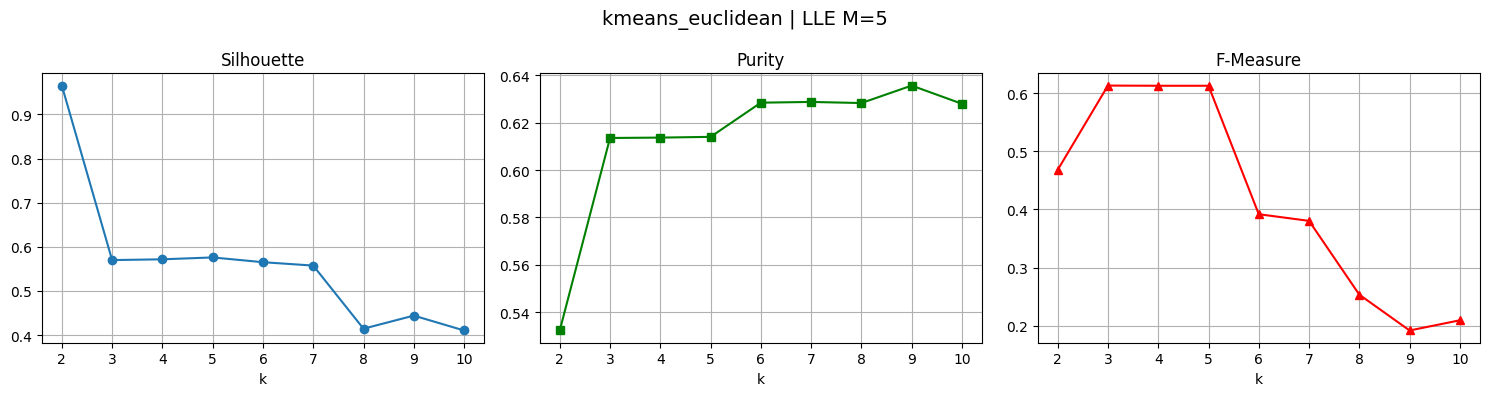

Best k = 2 with Silhouette = 0.9655

kmeans_cosine | M=5 | K=2 | Silhouette=0.4607 | Purity=0.6310 | F1=0.6310
kmeans_cosine | M=5 | K=3 | Silhouette=0.4853 | Purity=0.6267 | F1=0.4730
kmeans_cosine | M=5 | K=4 | Silhouette=0.3473 | Purity=0.6255 | F1=0.3221
kmeans_cosine | M=5 | K=5 | Silhouette=0.3535 | Purity=0.6277 | F1=0.1882
kmeans_cosine | M=5 | K=6 | Silhouette=0.3645 | Purity=0.6259 | F1=0.1272
kmeans_cosine | M=5 | K=7 | Silhouette=0.3393 | Purity=0.6252 | F1=0.1092
kmeans_cosine | M=5 | K=8 | Silhouette=0.2393 | Purity=0.6272 | F1=0.1645
kmeans_cosine | M=5 | K=9 | Silhouette=0.2343 | Purity=0.6330 | F1=0.0682
kmeans_cosine | M=5 | K=10 | Silhouette=0.2371 | Purity=0.6319 | F1=0.1435


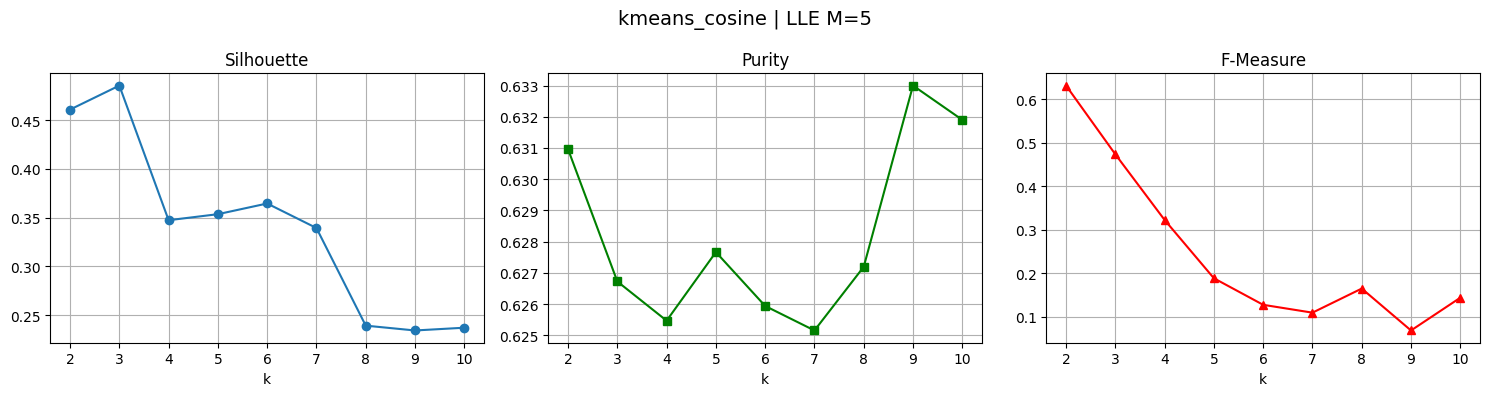

Best k = 3 with Silhouette = 0.4853

agglomerative | M=5 | K=2 | Silhouette=0.9655 | Purity=0.5323 | F1=0.4680
agglomerative | M=5 | K=3 | Silhouette=0.5536 | Purity=0.6325 | F1=0.4308
agglomerative | M=5 | K=4 | Silhouette=0.5590 | Purity=0.6330 | F1=0.4310
agglomerative | M=5 | K=5 | Silhouette=0.5629 | Purity=0.6333 | F1=0.0376
agglomerative | M=5 | K=6 | Silhouette=0.5654 | Purity=0.6333 | F1=0.4310
agglomerative | M=5 | K=7 | Silhouette=0.3565 | Purity=0.6333 | F1=0.0028
agglomerative | M=5 | K=8 | Silhouette=0.3622 | Purity=0.6333 | F1=0.2676
agglomerative | M=5 | K=9 | Silhouette=0.3691 | Purity=0.6336 | F1=0.2674
agglomerative | M=5 | K=10 | Silhouette=0.4081 | Purity=0.6336 | F1=0.2277


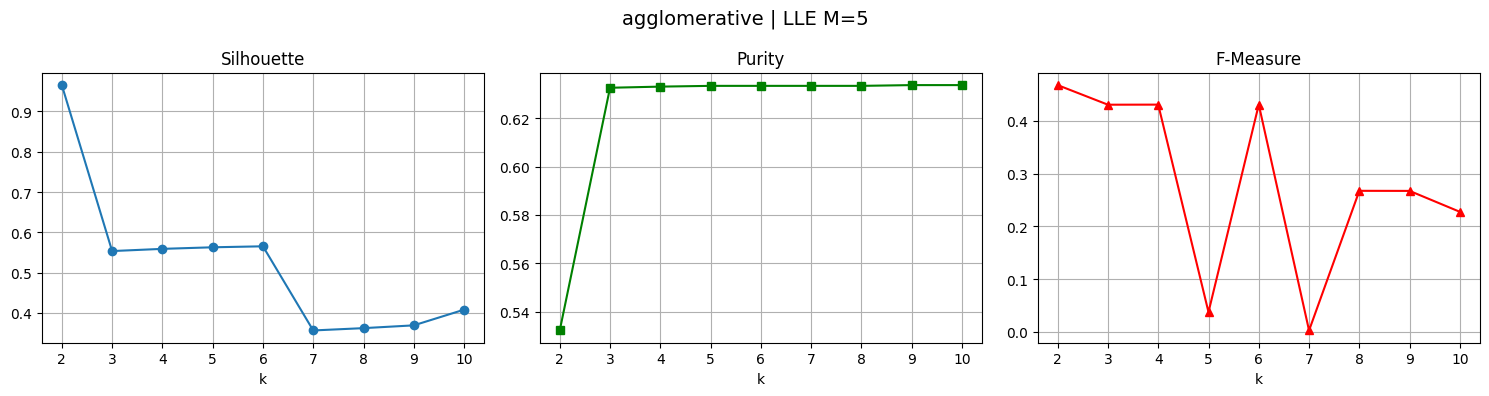

Best k = 2 with Silhouette = 0.9655

kmeans_euclidean | M=10 | K=2 | Silhouette=0.4009 | Purity=0.6333 | F1=0.6333
kmeans_euclidean | M=10 | K=3 | Silhouette=0.3599 | Purity=0.6230 | F1=0.3686
kmeans_euclidean | M=10 | K=4 | Silhouette=0.3738 | Purity=0.6231 | F1=0.3534
kmeans_euclidean | M=10 | K=5 | Silhouette=0.3771 | Purity=0.6244 | F1=0.3541
kmeans_euclidean | M=10 | K=6 | Silhouette=0.3125 | Purity=0.5812 | F1=0.3488
kmeans_euclidean | M=10 | K=7 | Silhouette=0.4228 | Purity=0.6270 | F1=0.3370
kmeans_euclidean | M=10 | K=8 | Silhouette=0.4331 | Purity=0.6269 | F1=0.3010
kmeans_euclidean | M=10 | K=9 | Silhouette=0.4327 | Purity=0.6277 | F1=0.3552
kmeans_euclidean | M=10 | K=10 | Silhouette=0.4353 | Purity=0.6280 | F1=0.2535


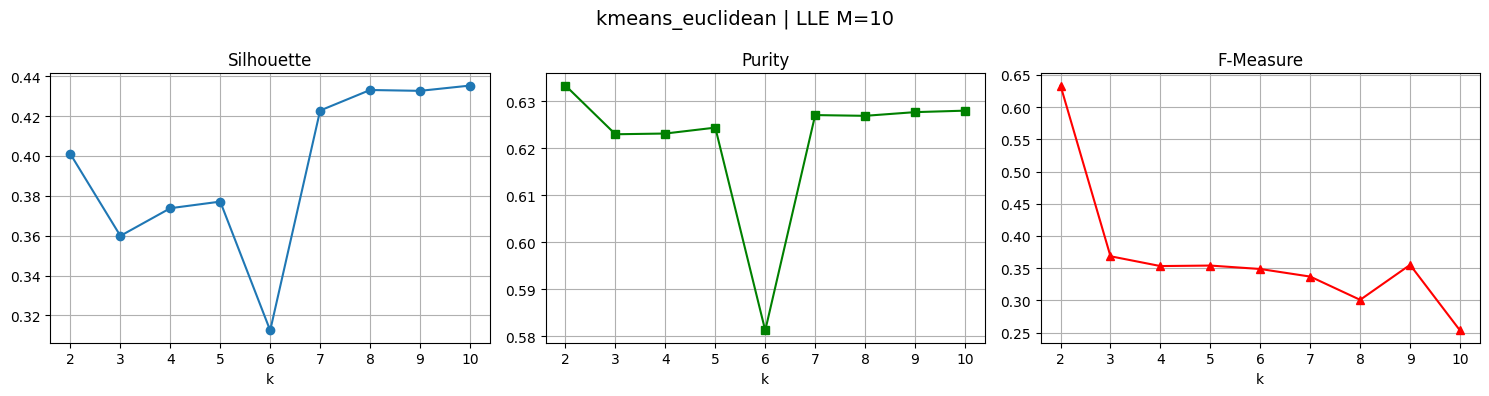

Best k = 10 with Silhouette = 0.4353

kmeans_cosine | M=10 | K=2 | Silhouette=0.2000 | Purity=0.5803 | F1=0.4197
kmeans_cosine | M=10 | K=3 | Silhouette=0.2463 | Purity=0.6299 | F1=0.3137
kmeans_cosine | M=10 | K=4 | Silhouette=0.3151 | Purity=0.6255 | F1=0.2644
kmeans_cosine | M=10 | K=5 | Silhouette=0.3532 | Purity=0.6255 | F1=0.1848
kmeans_cosine | M=10 | K=6 | Silhouette=0.3356 | Purity=0.6247 | F1=0.1564
kmeans_cosine | M=10 | K=7 | Silhouette=0.3070 | Purity=0.6264 | F1=0.2077
kmeans_cosine | M=10 | K=8 | Silhouette=0.2096 | Purity=0.6242 | F1=0.1929
kmeans_cosine | M=10 | K=9 | Silhouette=0.2440 | Purity=0.6261 | F1=0.1236
kmeans_cosine | M=10 | K=10 | Silhouette=0.2504 | Purity=0.6299 | F1=0.0756


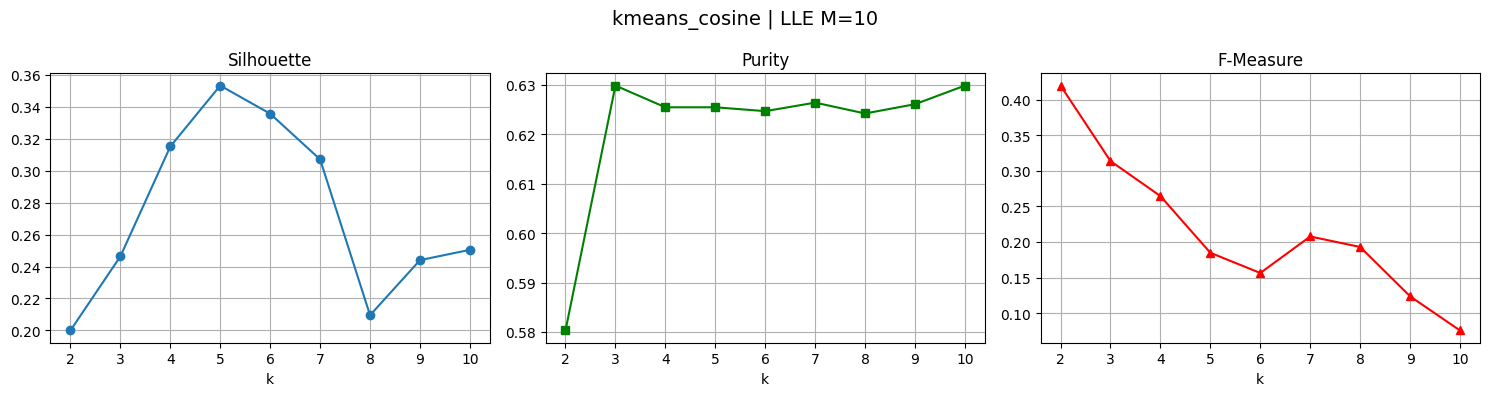

Best k = 5 with Silhouette = 0.3532

agglomerative | M=10 | K=2 | Silhouette=0.9485 | Purity=0.5323 | F1=0.4680
agglomerative | M=10 | K=3 | Silhouette=0.4309 | Purity=0.6167 | F1=0.4609
agglomerative | M=10 | K=4 | Silhouette=0.4346 | Purity=0.6170 | F1=0.4609
agglomerative | M=10 | K=5 | Silhouette=0.4389 | Purity=0.6175 | F1=0.0075
agglomerative | M=10 | K=6 | Silhouette=0.4315 | Purity=0.6175 | F1=0.4611
agglomerative | M=10 | K=7 | Silhouette=0.4358 | Purity=0.6179 | F1=0.4611
agglomerative | M=10 | K=8 | Silhouette=0.3189 | Purity=0.6179 | F1=0.4092
agglomerative | M=10 | K=9 | Silhouette=0.3233 | Purity=0.6183 | F1=0.0828
agglomerative | M=10 | K=10 | Silhouette=0.3561 | Purity=0.6183 | F1=0.4092


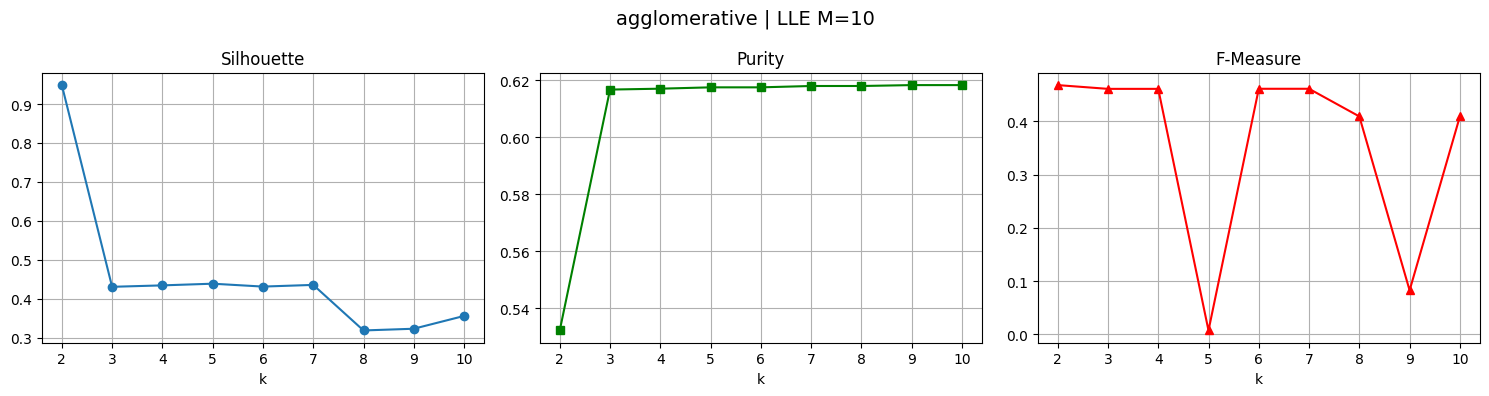

Best k = 2 with Silhouette = 0.9485

kmeans_euclidean | M=20 | K=2 | Silhouette=0.2917 | Purity=0.6179 | F1=0.3821
kmeans_euclidean | M=20 | K=3 | Silhouette=0.1221 | Purity=0.6190 | F1=0.3201
kmeans_euclidean | M=20 | K=4 | Silhouette=0.1330 | Purity=0.6184 | F1=0.3167
kmeans_euclidean | M=20 | K=5 | Silhouette=0.1280 | Purity=0.6176 | F1=0.1060
kmeans_euclidean | M=20 | K=6 | Silhouette=0.1653 | Purity=0.6167 | F1=0.3079
kmeans_euclidean | M=20 | K=7 | Silhouette=0.1291 | Purity=0.5913 | F1=0.3154
kmeans_euclidean | M=20 | K=8 | Silhouette=0.1367 | Purity=0.6175 | F1=0.2673
kmeans_euclidean | M=20 | K=9 | Silhouette=0.1467 | Purity=0.6128 | F1=0.2382
kmeans_euclidean | M=20 | K=10 | Silhouette=0.1703 | Purity=0.6189 | F1=0.2530


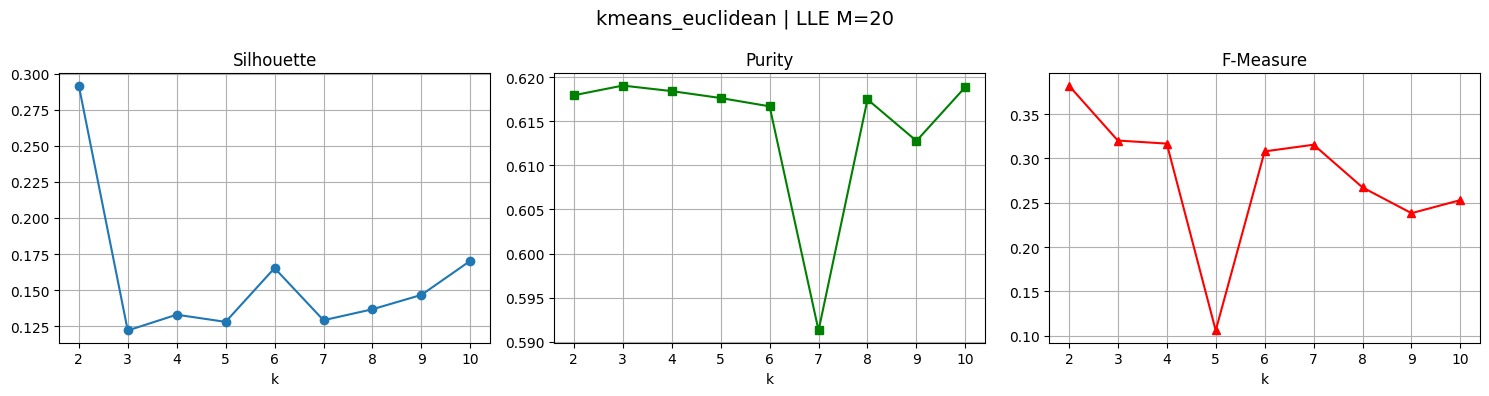

Best k = 2 with Silhouette = 0.2917

kmeans_cosine | M=20 | K=2 | Silhouette=0.0729 | Purity=0.5726 | F1=0.4274
kmeans_cosine | M=20 | K=3 | Silhouette=0.0307 | Purity=0.5911 | F1=0.3087
kmeans_cosine | M=20 | K=4 | Silhouette=0.0997 | Purity=0.6272 | F1=0.3331
kmeans_cosine | M=20 | K=5 | Silhouette=0.1006 | Purity=0.6413 | F1=0.1459
kmeans_cosine | M=20 | K=6 | Silhouette=0.1188 | Purity=0.6295 | F1=0.1501
kmeans_cosine | M=20 | K=7 | Silhouette=0.1245 | Purity=0.6430 | F1=0.1430
kmeans_cosine | M=20 | K=8 | Silhouette=0.1230 | Purity=0.6590 | F1=0.1013
kmeans_cosine | M=20 | K=9 | Silhouette=0.1620 | Purity=0.6446 | F1=0.1065
kmeans_cosine | M=20 | K=10 | Silhouette=0.1709 | Purity=0.6429 | F1=0.0897


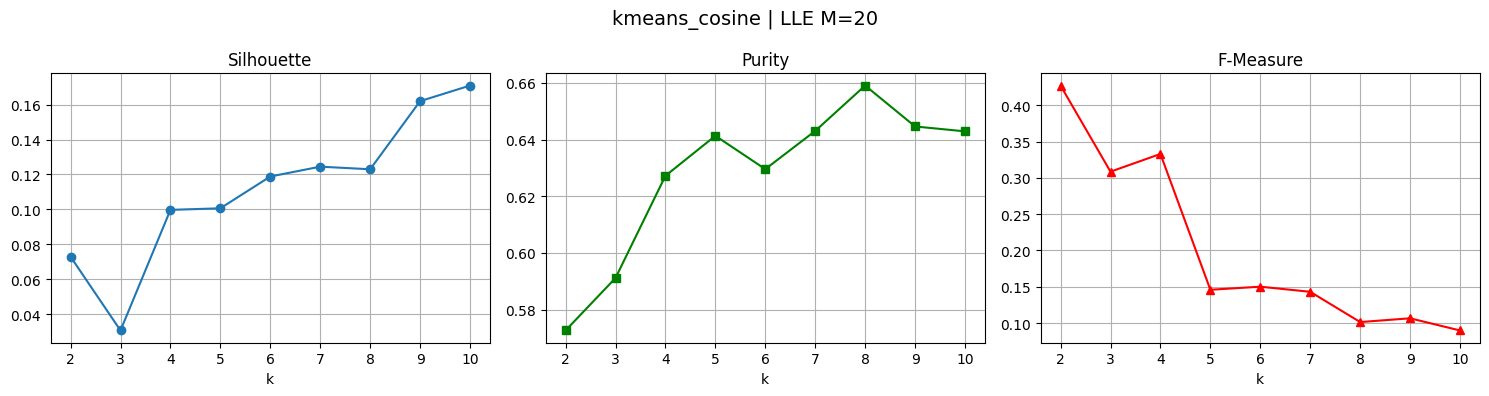

Best k = 10 with Silhouette = 0.1709

agglomerative | M=20 | K=2 | Silhouette=0.9148 | Purity=0.5323 | F1=0.4680
agglomerative | M=20 | K=3 | Silhouette=0.2969 | Purity=0.6226 | F1=0.4617
agglomerative | M=20 | K=4 | Silhouette=0.2994 | Purity=0.6230 | F1=0.4617
agglomerative | M=20 | K=5 | Silhouette=0.3018 | Purity=0.6233 | F1=0.4617
agglomerative | M=20 | K=6 | Silhouette=0.3046 | Purity=0.6237 | F1=0.0066
agglomerative | M=20 | K=7 | Silhouette=0.3070 | Purity=0.6237 | F1=0.4617
agglomerative | M=20 | K=8 | Silhouette=0.3099 | Purity=0.6242 | F1=0.0066
agglomerative | M=20 | K=9 | Silhouette=0.2984 | Purity=0.6242 | F1=0.4622
agglomerative | M=20 | K=10 | Silhouette=0.2744 | Purity=0.6242 | F1=0.4431


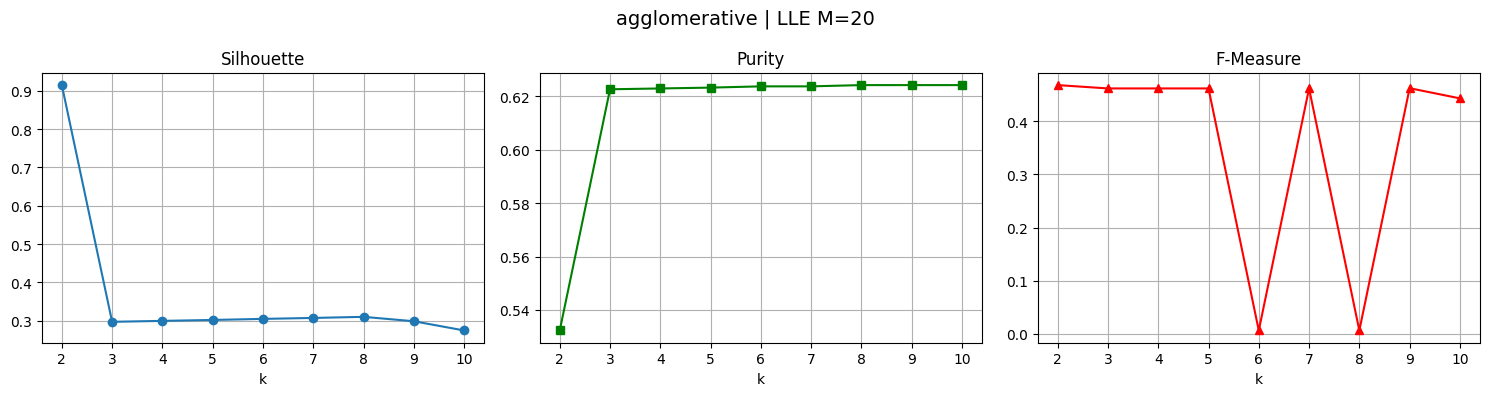

Best k = 2 with Silhouette = 0.9148



In [12]:


# Data
X = features
true_labels = y
lle_dims = [2, 3, 5, 10, 20]
cluster_range = range(2, 11)

def evaluate_clustering(method_name, X_proj, labels_true):
    silhouette_scores = []
    purity_scores = []
    fmeasure_scores = []
    best_k = -1
    best_silhouette = -1

    for k in cluster_range:
        if method_name == "kmeans_euclidean":
            model = KMeans(n_clusters=k, n_init="auto")
            labels = model.fit_predict(X_proj)

        elif method_name == "kmeans_cosine":
            X_norm = normalize(X_proj)
            model = KMeans(n_clusters=k, n_init="auto")
            labels = model.fit_predict(X_norm)

        elif method_name == "agglomerative":
            model = AgglomerativeClustering(n_clusters=k, metric="euclidean", linkage="ward")
            labels = model.fit_predict(X_proj)

        else:
            raise ValueError("Unknown clustering method")

        silhouette = silhouette_score(X_proj, labels)
        contingency = metrics.cluster.contingency_matrix(labels_true, labels)
        purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)
        fmeasure = f1_score(labels_true, labels, average="micro")

        silhouette_scores.append(silhouette)
        purity_scores.append(purity)
        fmeasure_scores.append(fmeasure)

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

        print(f"{method_name} | M={X_proj.shape[1]} | K={k} | Silhouette={silhouette:.4f} | Purity={purity:.4f} | F1={fmeasure:.4f}")

    # Plot results
    ks = list(cluster_range)
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"{method_name} | LLE M={X_proj.shape[1]}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.plot(ks, silhouette_scores, marker='o')
    plt.title("Silhouette")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(ks, purity_scores, marker='s', color='g')
    plt.title("Purity")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(ks, fmeasure_scores, marker='^', color='r')
    plt.title("F-Measure")
    plt.xlabel("k")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Best k = {best_k} with Silhouette = {best_silhouette:.4f}\n")

# Main loop over LLE dimensions
for dim in lle_dims:
    lle = LocallyLinearEmbedding(n_components=dim, n_neighbors=10)
    X_lle = lle.fit_transform(X)

    evaluate_clustering("kmeans_euclidean", X_lle, true_labels)
    evaluate_clustering("kmeans_cosine", X_lle, true_labels)
    evaluate_clustering("agglomerative", X_lle, true_labels)

kmeans_euclidean | M=2 | K=2 | Silhouette=0.5483 | Purity=0.5891 | F1=0.4109
kmeans_euclidean | M=2 | K=3 | Silhouette=0.5319 | Purity=0.5646 | F1=0.3220
kmeans_euclidean | M=2 | K=4 | Silhouette=0.5213 | Purity=0.5914 | F1=0.4006
kmeans_euclidean | M=2 | K=5 | Silhouette=0.5144 | Purity=0.5816 | F1=0.2947
kmeans_euclidean | M=2 | K=6 | Silhouette=0.5254 | Purity=0.5848 | F1=0.1744
kmeans_euclidean | M=2 | K=7 | Silhouette=0.5138 | Purity=0.5853 | F1=0.2088
kmeans_euclidean | M=2 | K=8 | Silhouette=0.5237 | Purity=0.5855 | F1=0.1636
kmeans_euclidean | M=2 | K=9 | Silhouette=0.5160 | Purity=0.5883 | F1=0.1335
kmeans_euclidean | M=2 | K=10 | Silhouette=0.5185 | Purity=0.5908 | F1=0.1589


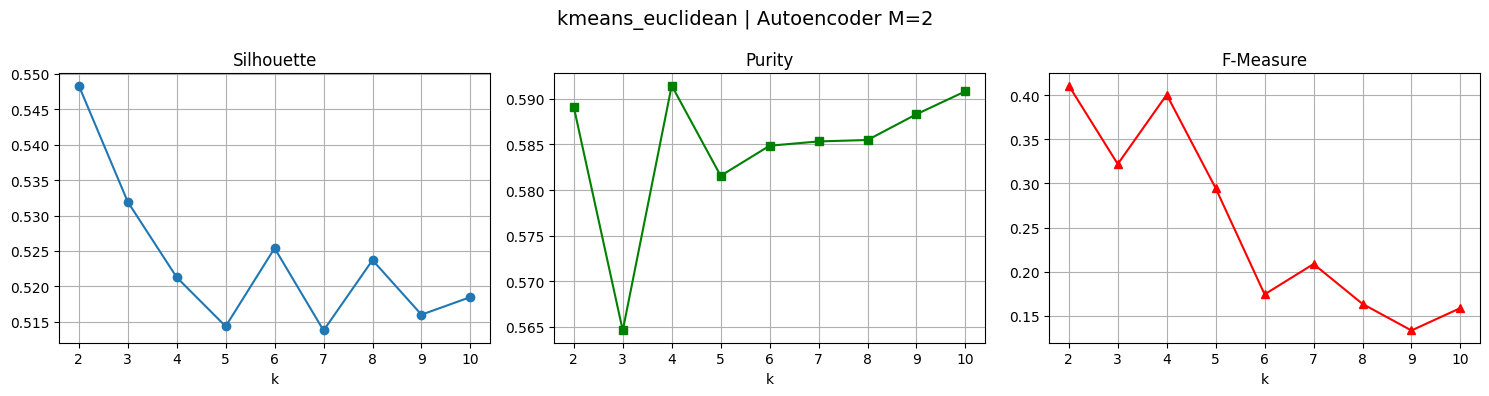

Best k = 2 with Silhouette = 0.5483

kmeans_cosine | M=2 | K=2 | Silhouette=0.0105 | Purity=0.5323 | F1=0.5287
kmeans_cosine | M=2 | K=3 | Silhouette=-0.0068 | Purity=0.5323 | F1=0.4026
kmeans_cosine | M=2 | K=4 | Silhouette=-0.0097 | Purity=0.5323 | F1=0.2981
kmeans_cosine | M=2 | K=5 | Silhouette=-0.0177 | Purity=0.5323 | F1=0.2550
kmeans_cosine | M=2 | K=6 | Silhouette=-0.0212 | Purity=0.5323 | F1=0.2878
kmeans_cosine | M=2 | K=7 | Silhouette=-0.0234 | Purity=0.5323 | F1=0.0889
kmeans_cosine | M=2 | K=8 | Silhouette=-0.0252 | Purity=0.5323 | F1=0.2207
kmeans_cosine | M=2 | K=9 | Silhouette=-0.0265 | Purity=0.5323 | F1=0.2812
kmeans_cosine | M=2 | K=10 | Silhouette=-0.0270 | Purity=0.5339 | F1=0.2666


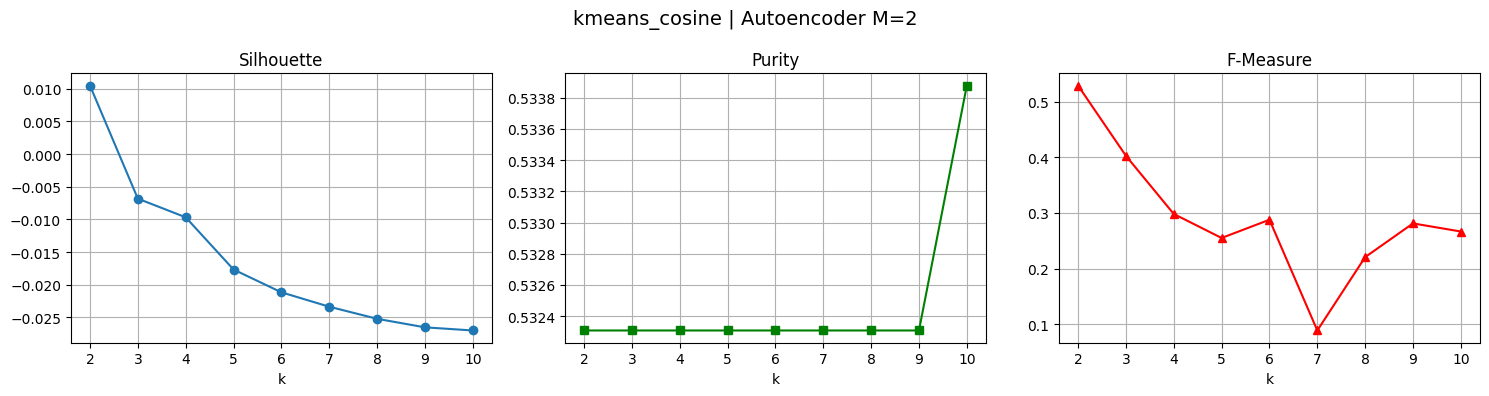

Best k = 2 with Silhouette = 0.0105

agglomerative | M=2 | K=2 | Silhouette=0.5418 | Purity=0.5927 | F1=0.4073
agglomerative | M=2 | K=3 | Silhouette=0.4992 | Purity=0.5927 | F1=0.5165
agglomerative | M=2 | K=4 | Silhouette=0.5160 | Purity=0.5927 | F1=0.3110
agglomerative | M=2 | K=5 | Silhouette=0.4796 | Purity=0.5927 | F1=0.3008
agglomerative | M=2 | K=6 | Silhouette=0.4817 | Purity=0.5927 | F1=0.0963
agglomerative | M=2 | K=7 | Silhouette=0.4940 | Purity=0.5927 | F1=0.2131
agglomerative | M=2 | K=8 | Silhouette=0.5159 | Purity=0.5927 | F1=0.1606
agglomerative | M=2 | K=9 | Silhouette=0.4879 | Purity=0.5927 | F1=0.0414
agglomerative | M=2 | K=10 | Silhouette=0.4879 | Purity=0.5927 | F1=0.0748


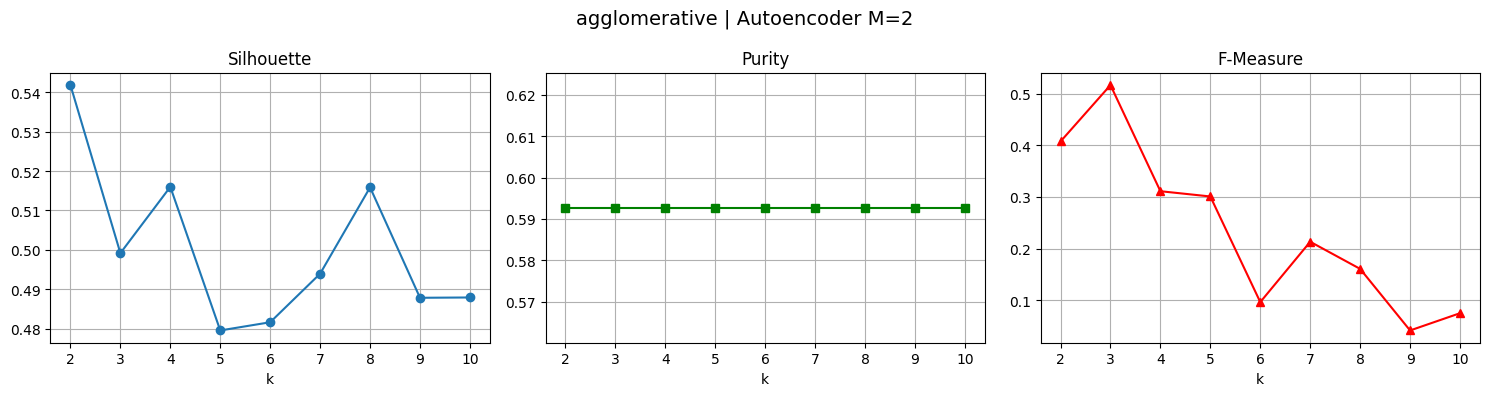

Best k = 2 with Silhouette = 0.5418

kmeans_euclidean | M=3 | K=2 | Silhouette=0.5488 | Purity=0.5872 | F1=0.5872
kmeans_euclidean | M=3 | K=3 | Silhouette=0.5318 | Purity=0.5652 | F1=0.3781
kmeans_euclidean | M=3 | K=4 | Silhouette=0.5211 | Purity=0.5913 | F1=0.2949
kmeans_euclidean | M=3 | K=5 | Silhouette=0.5188 | Purity=0.5833 | F1=0.2928
kmeans_euclidean | M=3 | K=6 | Silhouette=0.5240 | Purity=0.5896 | F1=0.1978
kmeans_euclidean | M=3 | K=7 | Silhouette=0.5140 | Purity=0.5908 | F1=0.2102
kmeans_euclidean | M=3 | K=8 | Silhouette=0.5255 | Purity=0.5870 | F1=0.2158
kmeans_euclidean | M=3 | K=9 | Silhouette=0.5205 | Purity=0.5921 | F1=0.2017
kmeans_euclidean | M=3 | K=10 | Silhouette=0.5215 | Purity=0.5850 | F1=0.1493


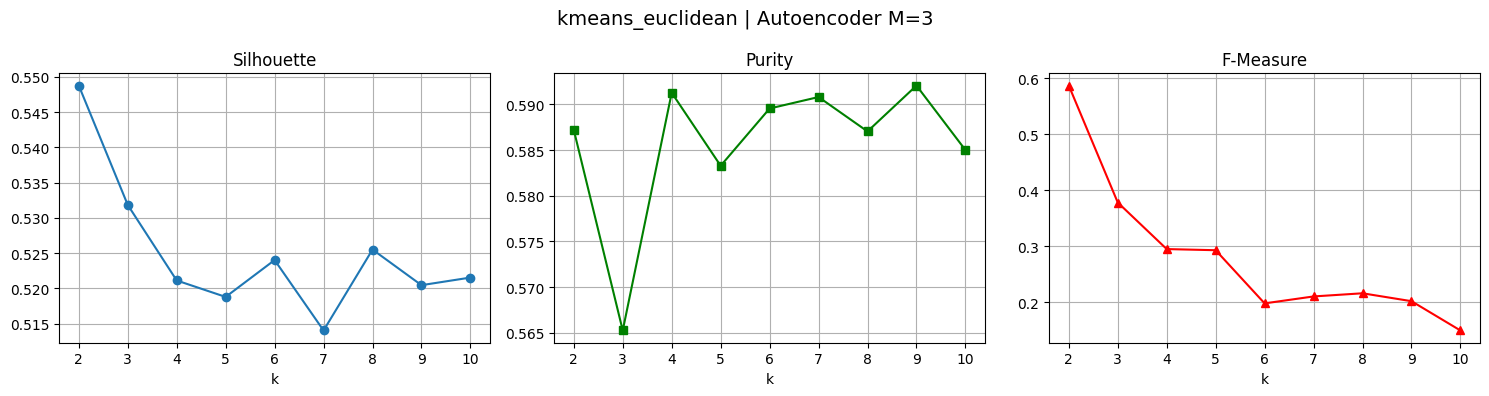

Best k = 2 with Silhouette = 0.5488

kmeans_cosine | M=3 | K=2 | Silhouette=0.0129 | Purity=0.5323 | F1=0.4975
kmeans_cosine | M=3 | K=3 | Silhouette=-0.0023 | Purity=0.5323 | F1=0.3137
kmeans_cosine | M=3 | K=4 | Silhouette=-0.0237 | Purity=0.5323 | F1=0.2922
kmeans_cosine | M=3 | K=5 | Silhouette=-0.0346 | Purity=0.5347 | F1=0.2771
kmeans_cosine | M=3 | K=6 | Silhouette=-0.0244 | Purity=0.5323 | F1=0.1281
kmeans_cosine | M=3 | K=7 | Silhouette=-0.0463 | Purity=0.5323 | F1=0.2417
kmeans_cosine | M=3 | K=8 | Silhouette=-0.0403 | Purity=0.5323 | F1=0.1868
kmeans_cosine | M=3 | K=9 | Silhouette=-0.0498 | Purity=0.5369 | F1=0.1269
kmeans_cosine | M=3 | K=10 | Silhouette=-0.0634 | Purity=0.5323 | F1=0.1330


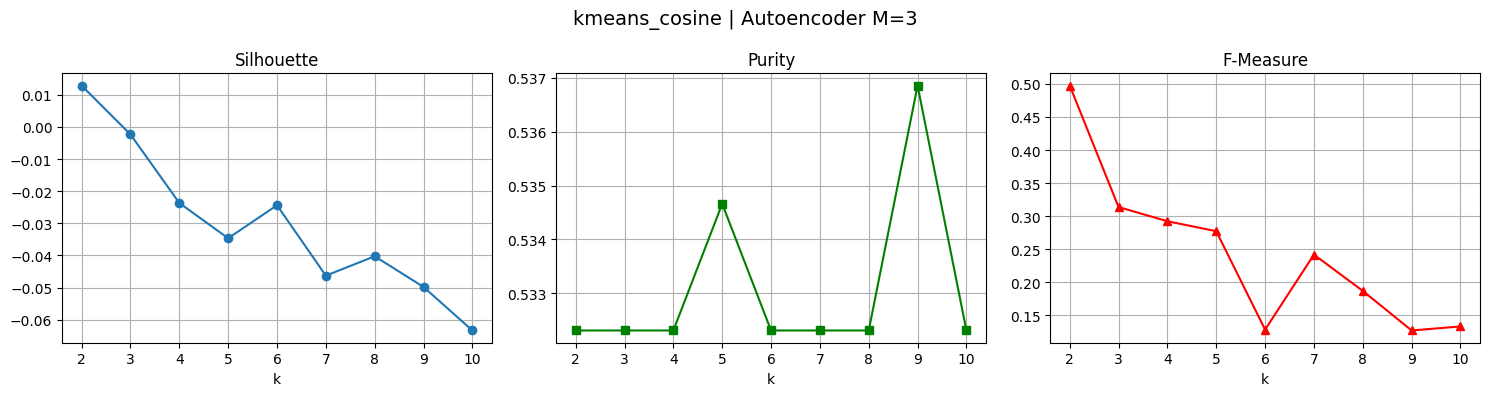

Best k = 2 with Silhouette = 0.0129

agglomerative | M=3 | K=2 | Silhouette=0.5522 | Purity=0.5853 | F1=0.5853
agglomerative | M=3 | K=3 | Silhouette=0.4992 | Purity=0.5853 | F1=0.2334
agglomerative | M=3 | K=4 | Silhouette=0.5227 | Purity=0.5853 | F1=0.2219
agglomerative | M=3 | K=5 | Silhouette=0.4778 | Purity=0.5853 | F1=0.2688
agglomerative | M=3 | K=6 | Silhouette=0.4621 | Purity=0.5903 | F1=0.1772
agglomerative | M=3 | K=7 | Silhouette=0.4572 | Purity=0.5903 | F1=0.1374
agglomerative | M=3 | K=8 | Silhouette=0.4849 | Purity=0.5903 | F1=0.1242
agglomerative | M=3 | K=9 | Silhouette=0.4974 | Purity=0.5932 | F1=0.1148
agglomerative | M=3 | K=10 | Silhouette=0.4950 | Purity=0.5932 | F1=0.1159


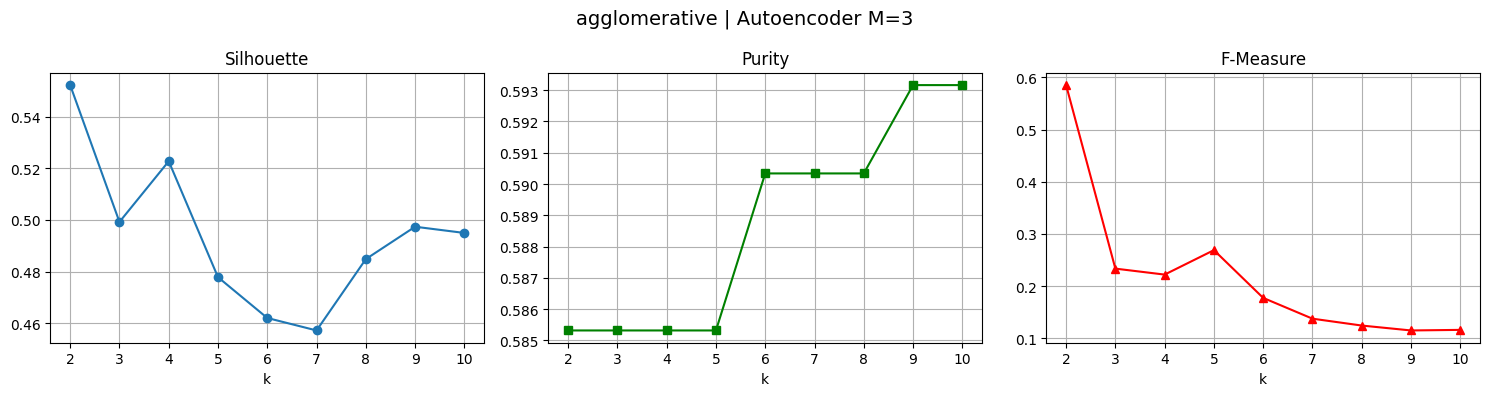

Best k = 2 with Silhouette = 0.5522

kmeans_euclidean | M=5 | K=2 | Silhouette=0.5483 | Purity=0.5888 | F1=0.4112
kmeans_euclidean | M=5 | K=3 | Silhouette=0.5319 | Purity=0.5646 | F1=0.1954
kmeans_euclidean | M=5 | K=4 | Silhouette=0.5223 | Purity=0.5885 | F1=0.3930
kmeans_euclidean | M=5 | K=5 | Silhouette=0.5213 | Purity=0.5836 | F1=0.2011
kmeans_euclidean | M=5 | K=6 | Silhouette=0.5253 | Purity=0.5847 | F1=0.1366
kmeans_euclidean | M=5 | K=7 | Silhouette=0.5107 | Purity=0.5845 | F1=0.2047
kmeans_euclidean | M=5 | K=8 | Silhouette=0.5239 | Purity=0.5855 | F1=0.1269
kmeans_euclidean | M=5 | K=9 | Silhouette=0.5186 | Purity=0.5864 | F1=0.1361
kmeans_euclidean | M=5 | K=10 | Silhouette=0.5215 | Purity=0.5852 | F1=0.1313


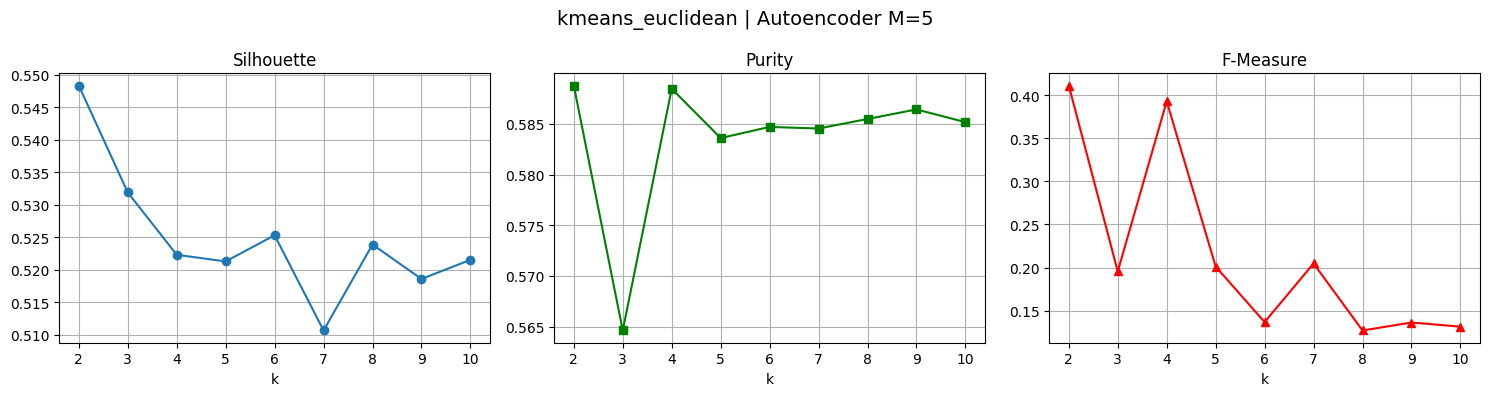

Best k = 2 with Silhouette = 0.5483

kmeans_cosine | M=5 | K=2 | Silhouette=-0.0022 | Purity=0.5323 | F1=0.5061
kmeans_cosine | M=5 | K=3 | Silhouette=-0.0126 | Purity=0.5323 | F1=0.3648
kmeans_cosine | M=5 | K=4 | Silhouette=-0.0101 | Purity=0.5323 | F1=0.2467
kmeans_cosine | M=5 | K=5 | Silhouette=-0.0201 | Purity=0.5323 | F1=0.2130
kmeans_cosine | M=5 | K=6 | Silhouette=-0.0230 | Purity=0.5323 | F1=0.1797
kmeans_cosine | M=5 | K=7 | Silhouette=-0.0315 | Purity=0.5323 | F1=0.1645
kmeans_cosine | M=5 | K=8 | Silhouette=-0.0303 | Purity=0.5323 | F1=0.1305
kmeans_cosine | M=5 | K=9 | Silhouette=-0.0320 | Purity=0.5323 | F1=0.1465
kmeans_cosine | M=5 | K=10 | Silhouette=-0.0475 | Purity=0.5331 | F1=0.0808


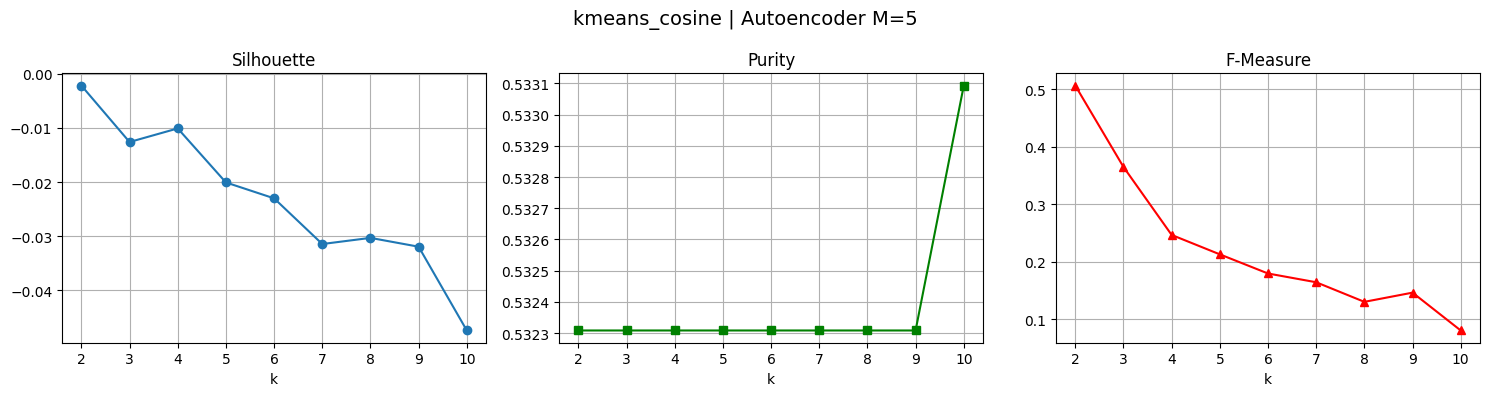

Best k = 2 with Silhouette = -0.0022

agglomerative | M=5 | K=2 | Silhouette=0.5525 | Purity=0.5870 | F1=0.5870
agglomerative | M=5 | K=3 | Silhouette=0.4720 | Purity=0.5870 | F1=0.2536
agglomerative | M=5 | K=4 | Silhouette=0.5060 | Purity=0.5870 | F1=0.3513
agglomerative | M=5 | K=5 | Silhouette=0.5220 | Purity=0.5870 | F1=0.1504
agglomerative | M=5 | K=6 | Silhouette=0.5038 | Purity=0.5870 | F1=0.1226
agglomerative | M=5 | K=7 | Silhouette=0.5150 | Purity=0.5870 | F1=0.2859
agglomerative | M=5 | K=8 | Silhouette=0.4919 | Purity=0.5936 | F1=0.1761
agglomerative | M=5 | K=9 | Silhouette=0.4861 | Purity=0.5936 | F1=0.1484
agglomerative | M=5 | K=10 | Silhouette=0.4831 | Purity=0.5960 | F1=0.0848


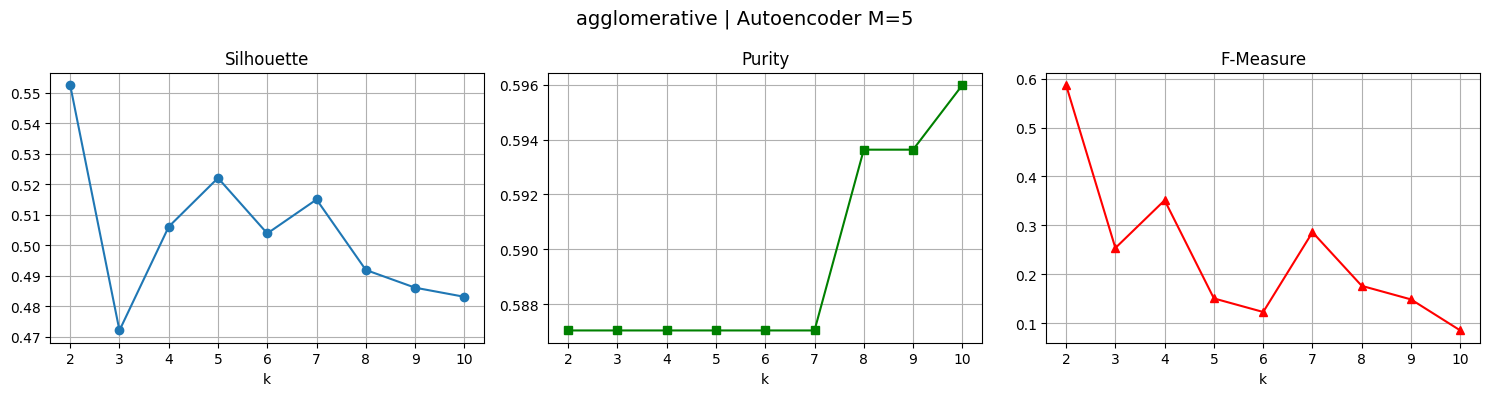

Best k = 2 with Silhouette = 0.5525

kmeans_euclidean | M=10 | K=2 | Silhouette=0.5484 | Purity=0.5889 | F1=0.4111
kmeans_euclidean | M=10 | K=3 | Silhouette=0.5319 | Purity=0.5645 | F1=0.3003
kmeans_euclidean | M=10 | K=4 | Silhouette=0.5223 | Purity=0.5889 | F1=0.2840
kmeans_euclidean | M=10 | K=5 | Silhouette=0.5144 | Purity=0.5825 | F1=0.2020
kmeans_euclidean | M=10 | K=6 | Silhouette=0.5247 | Purity=0.5877 | F1=0.2221
kmeans_euclidean | M=10 | K=7 | Silhouette=0.5151 | Purity=0.5861 | F1=0.2009
kmeans_euclidean | M=10 | K=8 | Silhouette=0.5261 | Purity=0.5925 | F1=0.1934
kmeans_euclidean | M=10 | K=9 | Silhouette=0.5186 | Purity=0.5864 | F1=0.1368
kmeans_euclidean | M=10 | K=10 | Silhouette=0.5157 | Purity=0.5963 | F1=0.1909


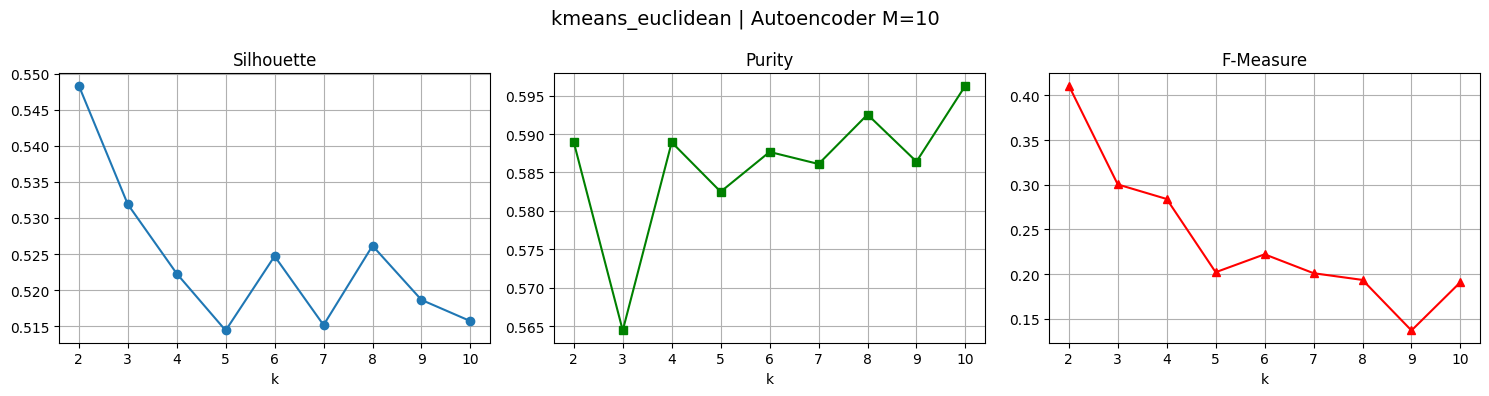

Best k = 2 with Silhouette = 0.5484

kmeans_cosine | M=10 | K=2 | Silhouette=0.0061 | Purity=0.5323 | F1=0.4898
kmeans_cosine | M=10 | K=3 | Silhouette=-0.0187 | Purity=0.5323 | F1=0.3496
kmeans_cosine | M=10 | K=4 | Silhouette=-0.0247 | Purity=0.5323 | F1=0.2754
kmeans_cosine | M=10 | K=5 | Silhouette=-0.0415 | Purity=0.5323 | F1=0.2222
kmeans_cosine | M=10 | K=6 | Silhouette=-0.0506 | Purity=0.5323 | F1=0.2331
kmeans_cosine | M=10 | K=7 | Silhouette=-0.0471 | Purity=0.5323 | F1=0.1636
kmeans_cosine | M=10 | K=8 | Silhouette=-0.0864 | Purity=0.5339 | F1=0.1289
kmeans_cosine | M=10 | K=9 | Silhouette=-0.0505 | Purity=0.5329 | F1=0.1375
kmeans_cosine | M=10 | K=10 | Silhouette=-0.0521 | Purity=0.5361 | F1=0.1132


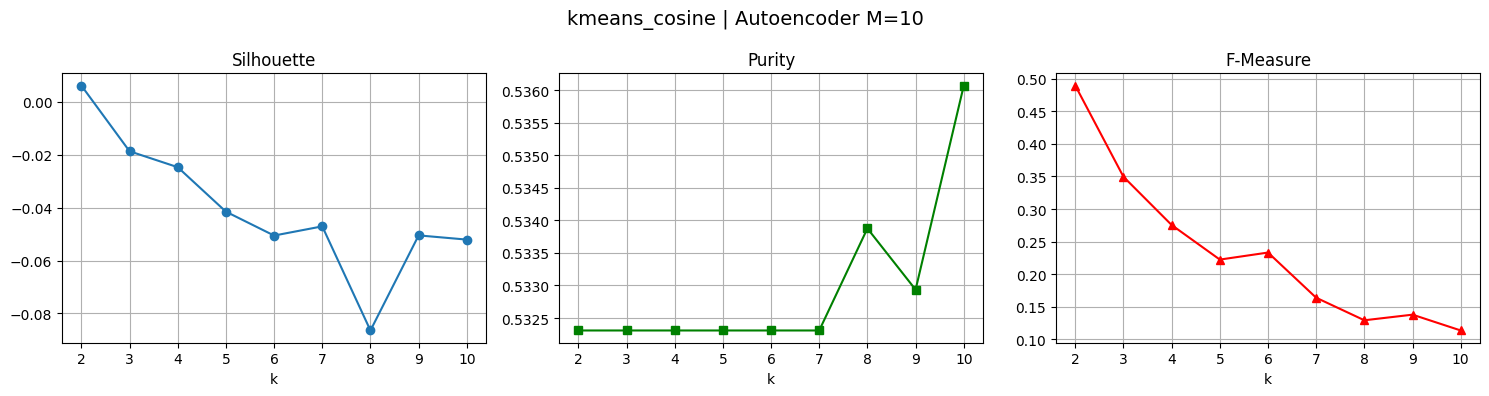

Best k = 2 with Silhouette = 0.0061

agglomerative | M=10 | K=2 | Silhouette=0.5477 | Purity=0.5740 | F1=0.5740
agglomerative | M=10 | K=3 | Silhouette=0.5191 | Purity=0.5740 | F1=0.2221
agglomerative | M=10 | K=4 | Silhouette=0.5120 | Purity=0.5740 | F1=0.2444
agglomerative | M=10 | K=5 | Silhouette=0.4619 | Purity=0.5740 | F1=0.2671
agglomerative | M=10 | K=6 | Silhouette=0.4986 | Purity=0.5897 | F1=0.1432
agglomerative | M=10 | K=7 | Silhouette=0.5074 | Purity=0.5922 | F1=0.1343
agglomerative | M=10 | K=8 | Silhouette=0.5066 | Purity=0.5922 | F1=0.1192
agglomerative | M=10 | K=9 | Silhouette=0.5032 | Purity=0.5922 | F1=0.1578
agglomerative | M=10 | K=10 | Silhouette=0.4909 | Purity=0.5922 | F1=0.2069


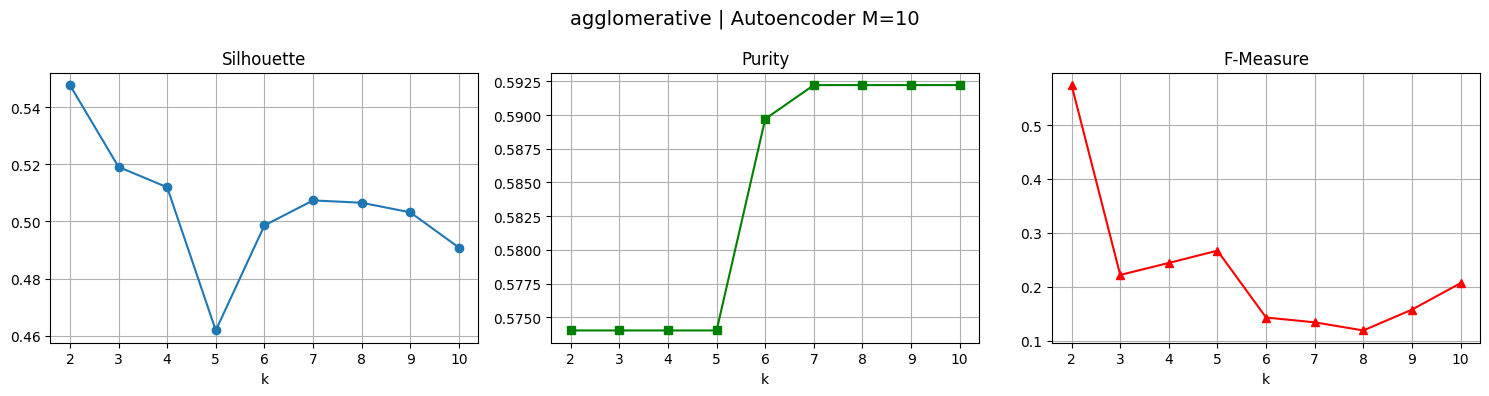

Best k = 2 with Silhouette = 0.5477

kmeans_euclidean | M=20 | K=2 | Silhouette=0.5484 | Purity=0.5888 | F1=0.5888
kmeans_euclidean | M=20 | K=3 | Silhouette=0.5319 | Purity=0.5645 | F1=0.3919
kmeans_euclidean | M=20 | K=4 | Silhouette=0.5219 | Purity=0.5897 | F1=0.2073
kmeans_euclidean | M=20 | K=5 | Silhouette=0.5215 | Purity=0.5836 | F1=0.2390
kmeans_euclidean | M=20 | K=6 | Silhouette=0.5253 | Purity=0.5856 | F1=0.0745
kmeans_euclidean | M=20 | K=7 | Silhouette=0.5179 | Purity=0.5848 | F1=0.1931
kmeans_euclidean | M=20 | K=8 | Silhouette=0.5260 | Purity=0.5925 | F1=0.1579
kmeans_euclidean | M=20 | K=9 | Silhouette=0.5186 | Purity=0.5864 | F1=0.1117
kmeans_euclidean | M=20 | K=10 | Silhouette=0.5167 | Purity=0.5965 | F1=0.1937


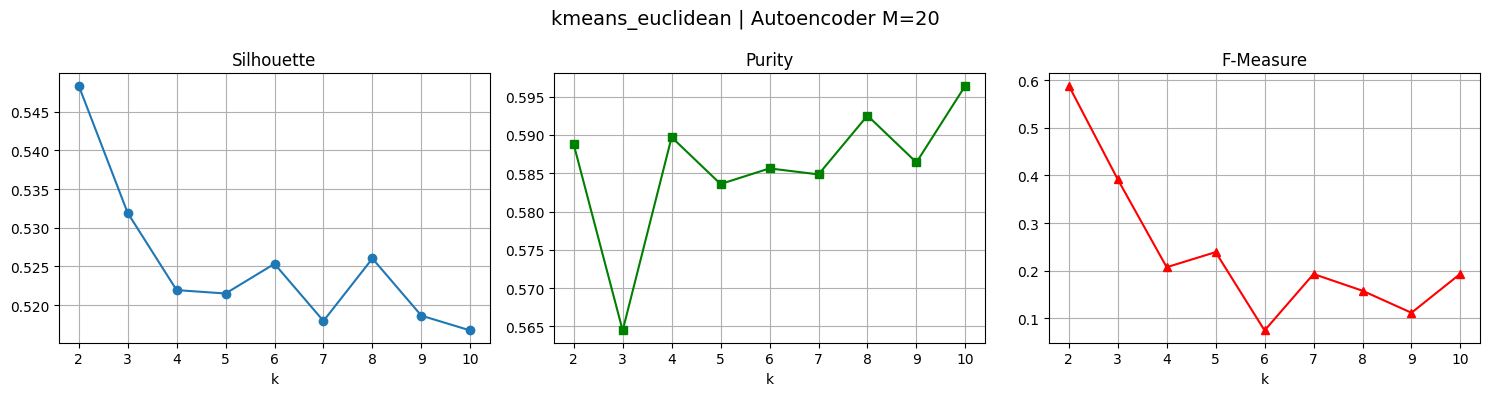

Best k = 2 with Silhouette = 0.5484

kmeans_cosine | M=20 | K=2 | Silhouette=0.0018 | Purity=0.5323 | F1=0.5003
kmeans_cosine | M=20 | K=3 | Silhouette=-0.0084 | Purity=0.5323 | F1=0.4109
kmeans_cosine | M=20 | K=4 | Silhouette=-0.0150 | Purity=0.5323 | F1=0.3214
kmeans_cosine | M=20 | K=5 | Silhouette=-0.0240 | Purity=0.5323 | F1=0.2338
kmeans_cosine | M=20 | K=6 | Silhouette=-0.0163 | Purity=0.5323 | F1=0.2072
kmeans_cosine | M=20 | K=7 | Silhouette=-0.0347 | Purity=0.5323 | F1=0.1546
kmeans_cosine | M=20 | K=8 | Silhouette=-0.0349 | Purity=0.5323 | F1=0.1198
kmeans_cosine | M=20 | K=9 | Silhouette=-0.0412 | Purity=0.5325 | F1=0.0947
kmeans_cosine | M=20 | K=10 | Silhouette=-0.0421 | Purity=0.5326 | F1=0.0852


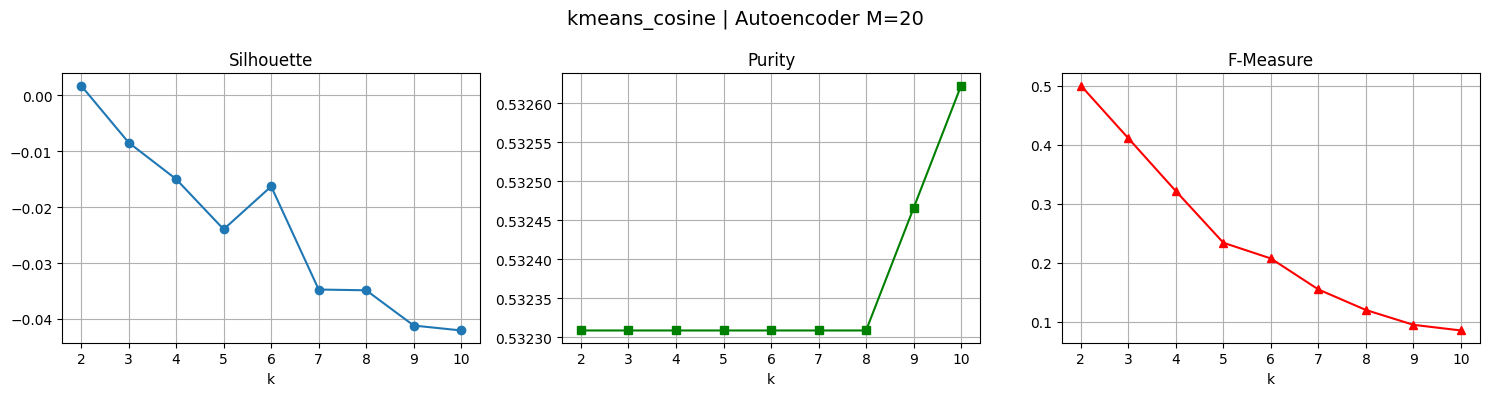

Best k = 2 with Silhouette = 0.0018

agglomerative | M=20 | K=2 | Silhouette=0.5135 | Purity=0.5816 | F1=0.4184
agglomerative | M=20 | K=3 | Silhouette=0.5082 | Purity=0.5816 | F1=0.3661
agglomerative | M=20 | K=4 | Silhouette=0.5063 | Purity=0.5816 | F1=0.1959
agglomerative | M=20 | K=5 | Silhouette=0.4997 | Purity=0.5816 | F1=0.3359
agglomerative | M=20 | K=6 | Silhouette=0.4677 | Purity=0.5853 | F1=0.2386
agglomerative | M=20 | K=7 | Silhouette=0.4980 | Purity=0.5853 | F1=0.0805
agglomerative | M=20 | K=8 | Silhouette=0.5052 | Purity=0.5853 | F1=0.1553
agglomerative | M=20 | K=9 | Silhouette=0.5094 | Purity=0.5878 | F1=0.1198
agglomerative | M=20 | K=10 | Silhouette=0.4969 | Purity=0.5878 | F1=0.1658


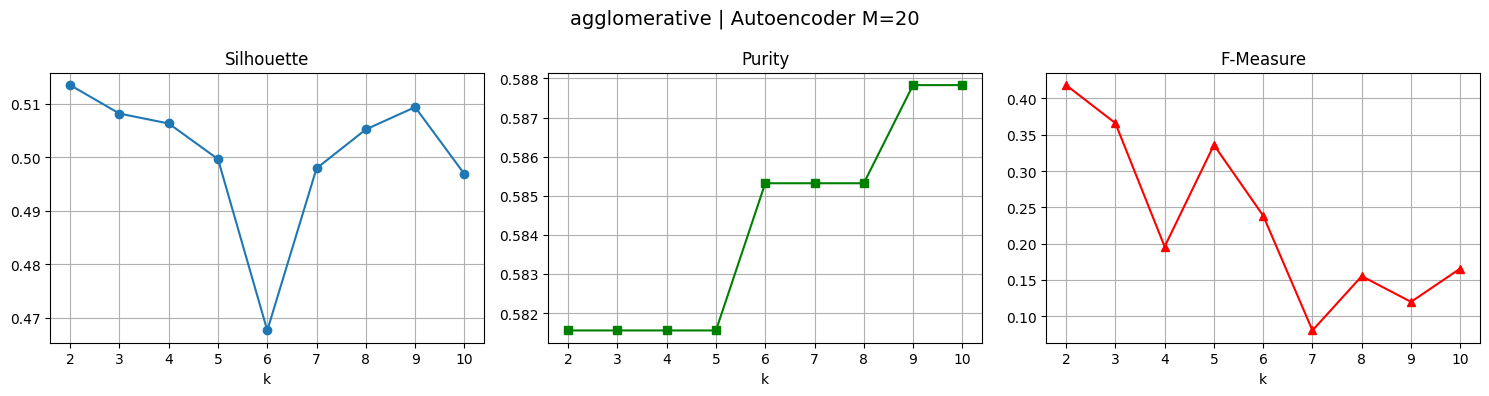

Best k = 2 with Silhouette = 0.5135



In [13]:

# --- Load saved encoded outputs from .npy files (we made them before)---
encoded_outputs = {
    2: np.load("encoded_outputs/x_encoded_2.npy"),
    3: np.load("encoded_outputs/x_encoded_3.npy"),
    5: np.load("encoded_outputs/x_encoded_5.npy"),
    10: np.load("encoded_outputs/x_encoded_10.npy"),
    20: np.load("encoded_outputs/x_encoded_20.npy")
}

true_labels = y
cluster_range = range(2, 11)

# Clustering Evaluation Function 
def evaluate_clustering(method_name, X_proj, labels_true):
    silhouette_scores = []
    purity_scores = []
    fmeasure_scores = []
    best_k = -1
    best_silhouette = -1

    for k in cluster_range:
        if method_name == "kmeans_euclidean":
            model = KMeans(n_clusters=k, n_init="auto")
            labels = model.fit_predict(X_proj)
        elif method_name == "kmeans_cosine":
            X_norm = normalize(X_proj)
            model = KMeans(n_clusters=k, n_init="auto")
            labels = model.fit_predict(X_norm)
        elif method_name == "agglomerative":
            model = AgglomerativeClustering(n_clusters=k, metric="euclidean", linkage="ward")
            labels = model.fit_predict(X_proj)
        else:
            raise ValueError("Unknown clustering method")

        if len(np.unique(labels)) <= 1:
            silhouette = -1
            print(f"{method_name} | K={k} | Only one cluster found.")
        else:
            silhouette = silhouette_score(X_proj, labels)

        contingency = metrics.cluster.contingency_matrix(labels_true, labels)
        purity = np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)
        fmeasure = f1_score(labels_true, labels, average="micro")

        silhouette_scores.append(silhouette)
        purity_scores.append(purity)
        fmeasure_scores.append(fmeasure)

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = k

        print(f"{method_name} | M={X_proj.shape[1]} | K={k} | Silhouette={silhouette:.4f} | Purity={purity:.4f} | F1={fmeasure:.4f}")

    # --- Plot ---
    ks = list(cluster_range)
    plt.figure(figsize=(15, 4))
    plt.suptitle(f"{method_name} | Autoencoder M={X_proj.shape[1]}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.plot(ks, silhouette_scores, marker='o')
    plt.title("Silhouette")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(ks, purity_scores, marker='s', color='g')
    plt.title("Purity")
    plt.xlabel("k")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(ks, fmeasure_scores, marker='^', color='r')
    plt.title("F-Measure")
    plt.xlabel("k")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Best k = {best_k} with Silhouette = {best_silhouette:.4f}\n")

#  Run clustering for each encoded dimension 
for dim, x_encoded in encoded_outputs.items():
    evaluate_clustering("kmeans_euclidean", x_encoded, true_labels)
    evaluate_clustering("kmeans_cosine", x_encoded, true_labels)
    evaluate_clustering("agglomerative", x_encoded, true_labels)